In [5]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import sklearn.metrics
import torch
import torch.optim as optim
from torch import nn
import time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [6]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [7]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

Loading the Data

In [8]:
df = pd.read_csv("heart_data.csv")
df

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2       1  
2        2   0     2       1  
3        2   0     2       1  
4        2   0     2       1  
..     ...  ..   ...     ...  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0  

[303 rows x 14 columns]

# Data Exploration

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Exploring more information about the target variable

In [10]:
# Splitting the data into a positive target and a negative target
hdpositive = df.loc[df['target']== 1, ['target','age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]
hdpositive

target  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
0         1   63    1   3       145   233    1        0      150      0   
1         1   37    1   2       130   250    0        1      187      0   
2         1   41    0   1       130   204    0        0      172      0   
3         1   56    1   1       120   236    0        1      178      0   
4         1   57    0   0       120   354    0        1      163      1   
..      ...  ...  ...  ..       ...   ...  ...      ...      ...    ...   
160       1   56    1   1       120   240    0        1      169      0   
161       1   55    0   1       132   342    0        1      166      0   
162       1   41    1   1       120   157    0        1      182      0   
163       1   38    1   2       138   175    0        1      173      0   
164       1   38    1   2       138   175    0        1      173      0   

     oldpeak  slope  ca  thal  
0        2.3      0   0     1  
1        3.5      0   0     2  
2        1.4      2   0     2  
3        0.8      2   0     2  
4        0.6      2   0     2  
..       ...    ...  ..   ...  
160      0.0      0   0     2  
161      1.2      2   0     2  
162      0.0      2   0     2  
163      0.0      2   4     2  
164      0.0      2   4     2  

[165 rows x 14 columns]

In [11]:
# Splitting the data into a positive target and a negative target
hdnegative = df.loc[df['target']== 0, ['target','age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]
hdnegative

target  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
165       0   67    1   0       160   286    0        0      108      1   
166       0   67    1   0       120   229    0        0      129      1   
167       0   62    0   0       140   268    0        0      160      0   
168       0   63    1   0       130   254    0        0      147      0   
169       0   53    1   0       140   203    1        0      155      1   
..      ...  ...  ...  ..       ...   ...  ...      ...      ...    ...   
298       0   57    0   0       140   241    0        1      123      1   
299       0   45    1   3       110   264    0        1      132      0   
300       0   68    1   0       144   193    1        1      141      0   
301       0   57    1   0       130   131    0        1      115      1   
302       0   57    0   1       130   236    0        0      174      0   

     oldpeak  slope  ca  thal  
165      1.5      1   3     2  
166      2.6      1   2     3  
167      3.6      0   2     2  
168      1.4      1   1     3  
169      3.1      0   0     3  
..       ...    ...  ..   ...  
298      0.2      1   0     3  
299      1.2      1   0     3  
300      3.4      1   2     3  
301      1.2      1   1     3  
302      0.0      1   1     2  

[138 rows x 14 columns]

In [12]:
df['target'].describe()

count    303.000000
mean       0.544554
std        0.498835
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

In [13]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

<Axes: xlabel='target', ylabel='Density'>

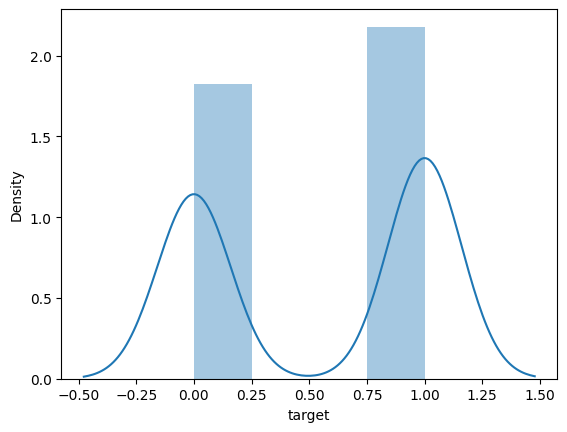

In [14]:
sns.distplot(df['target'])

In [15]:
print("Skewness: %f" % df['target'].skew())
print("Kurtosis: %f" % df['target'].kurt())

Skewness: -0.179821
Kurtosis: -1.980783


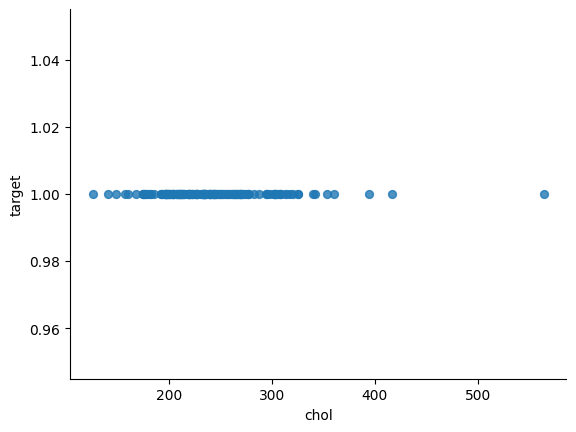

In [16]:
# @title heart disease vs chol - positive
# Looking at the posssible correlation between heart disease and cholestorol
hdpositive.plot(kind='scatter', x='chol', y='target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [17]:
hdpositive['chol'].describe()

count    165.000000
mean     242.230303
std       53.552872
min      126.000000
25%      208.000000
50%      234.000000
75%      267.000000
max      564.000000
Name: chol, dtype: float64

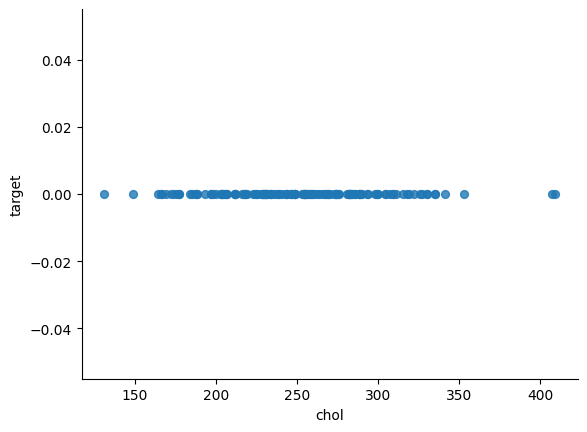

In [18]:
# @title heart disease vs chol - negative
# Looking at the posssible correlation between an absence of heart disease and cholestorol
hdnegative.plot(kind='scatter', x='chol', y='target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [19]:
hdnegative['chol'].describe()

count    138.000000
mean     251.086957
std       49.454614
min      131.000000
25%      217.250000
50%      249.000000
75%      283.000000
max      409.000000
Name: chol, dtype: float64

In [20]:
hdnegative['chol'].median()

249.0

Conclusion:
The higher cholestorol for negative vs. positive proves the need for data normalization (which will be done in the next step - cleaning and preprocessing)

In [21]:
# @title Correlation Matrix
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach','exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
correlations = df.corr()
print (correlations)

               age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.098447 -0.068653  0.279351  0.213678  0.121308   
sex      -0.098447  1.000000 -0.049353 -0.056769 -0.197912  0.045032   
cp       -0.068653 -0.049353  1.000000  0.047608 -0.076904  0.094444   
trestbps  0.279351 -0.056769  0.047608  1.000000  0.123174  0.177531   
chol      0.213678 -0.197912 -0.076904  0.123174  1.000000  0.013294   
fbs       0.121308  0.045032  0.094444  0.177531  0.013294  1.000000   
restecg  -0.116211 -0.058196  0.044421 -0.114103 -0.151040 -0.084189   
thalach  -0.398522 -0.044020  0.295762 -0.046698 -0.009940 -0.008567   
exang     0.096801  0.141664 -0.394280  0.067616  0.067023  0.025665   
oldpeak   0.210013  0.096093 -0.149230  0.193216  0.053952  0.005747   
slope    -0.168814 -0.030711  0.119717 -0.121475 -0.004038 -0.059894   
ca        0.276326  0.118261 -0.181053  0.101389  0.070511  0.137979   
thal      0.068001  0.210041 -0.161736  0.062210  0.098803 -0.03

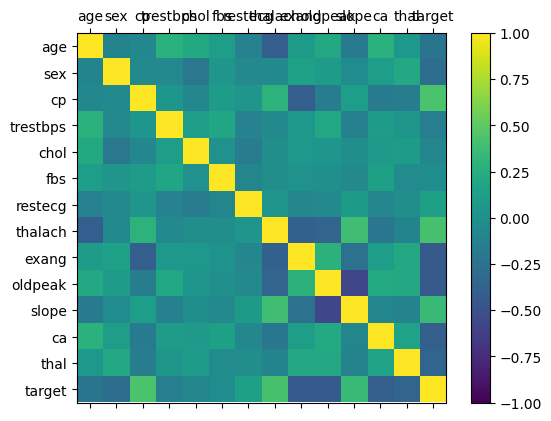

In [22]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,30)))
cax = ax.matshow(correlations, interpolation='nearest', vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 14, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(columns)
ax.set_yticklabels(columns)
plt.show()

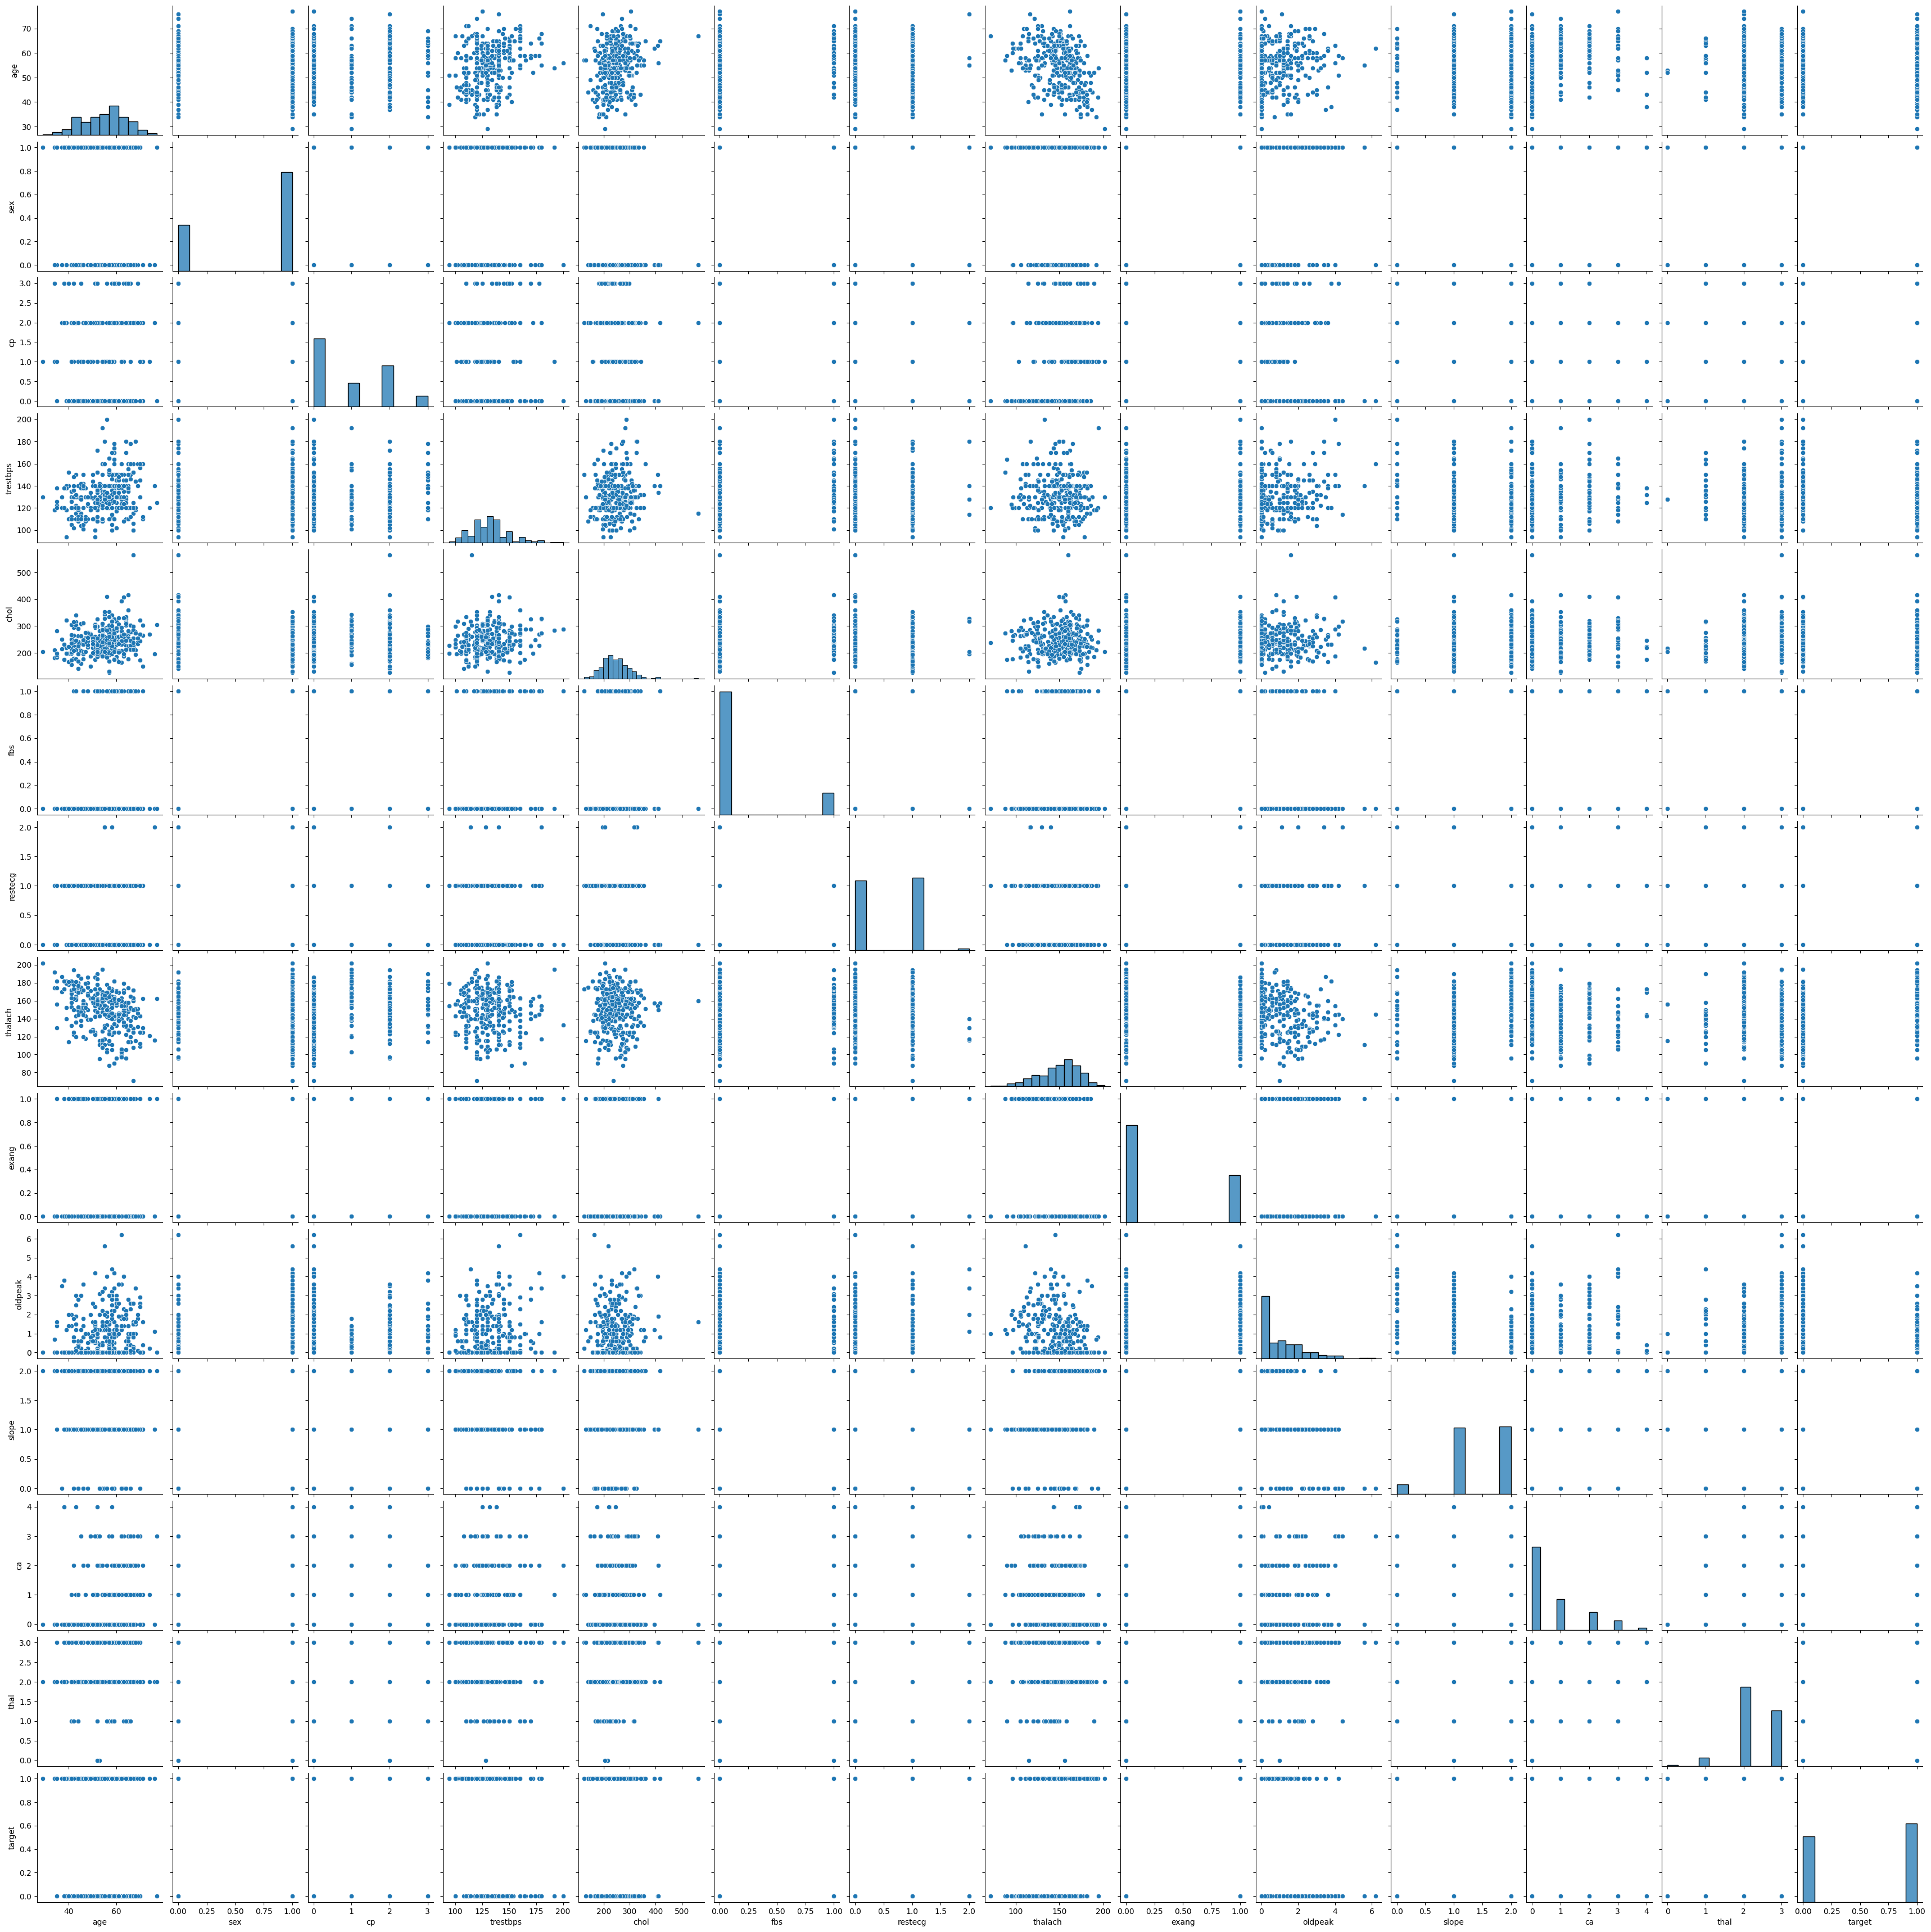

In [23]:
sns.pairplot(df)

<Axes: ylabel='Density'>

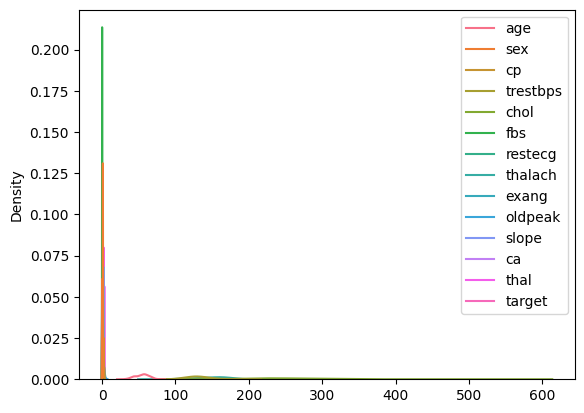

In [24]:
sns.kdeplot(df)

In [25]:
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

# Data Preprocessing

In [26]:
# Load the data
data = df

# Check for missing values
missing_values = data.isnull().sum()


In [27]:
Q1 = data[['trestbps', 'chol', 'thalach', 'oldpeak']].quantile(0.25)
Q3 = data[['trestbps', 'chol', 'thalach', 'oldpeak']].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers using IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((data[['trestbps', 'chol', 'thalach', 'oldpeak']] < lower_bound) | (data[['trestbps', 'chol', 'thalach', 'oldpeak']] > upper_bound)).any(axis=1)

# Filter the dataset to print only the outliers
outliers_df = data[outliers]
print(outliers_df)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
8     52    1   2       172   199    1        1      162      0      0.5   
28    65    0   2       140   417    1        0      157      0      0.8   
85    67    0   2       115   564    0        0      160      0      1.6   
96    62    0   0       140   394    0        0      157      0      1.2   
101   59    1   3       178   270    0        0      145      0      4.2   
110   64    0   0       180   325    0        1      154      1      0.0   
203   68    1   2       180   274    1        0      150      1      1.6   
204   62    0   0       160   164    0        0      145      0      6.2   
220   63    0   0       150   407    0        0      154      0      4.0   
221   55    1   0       140   217    0        1      111      1      5.6   
223   56    0   0       200   288    1        0      133      1      4.0   
241   59    0   0       174   249    0        1      143      1      0.0   
246   56    

In [28]:
# Calculate the average for each attribute
average_values = data[['trestbps', 'chol', 'thalach', 'oldpeak']].mean()

# Display the average values
print("Average values for each attribute:")
print(average_values)

Average values for each attribute:
trestbps    131.623762
chol        246.264026
thalach     149.646865
oldpeak       1.039604
dtype: float64


In [29]:
# Cap the outliers that are outside of the normal bounds

data['trestbps'] = data['trestbps'].clip(lower=lower_bound['trestbps'], upper=upper_bound['trestbps'])
data['chol'] = data['chol'].clip(lower=lower_bound['chol'], upper=upper_bound['chol'])
data['thalach'] = data['thalach'].clip(lower=lower_bound['thalach'], upper=upper_bound['thalach'])
data['oldpeak'] = data['oldpeak'].clip(lower=lower_bound['oldpeak'], upper=upper_bound['oldpeak'])

In [30]:
# Define numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Min-Max normalization for 'age' column
age_scaler = MinMaxScaler()
df['scaled_age'] = age_scaler.fit_transform(data[['age']])

# Calculate Z-score for other numerical columns
z_score_scaler = StandardScaler()
df[numerical_cols] = z_score_scaler.fit_transform(data[numerical_cols])

# Verify the DataFrame
df.head()

age  sex  cp  trestbps      chol  fbs  restecg   thalach  exang  \
0  0.952197    1   3  0.828728 -0.255601    1        0  0.013543      0   
1 -1.915313    1   2 -0.077351  0.102487    0        1  1.641748      0   
2 -1.474158    0   1 -0.077351 -0.866457    0        0  0.981665      0   
3  0.180175    1   1 -0.681403 -0.192409    0        1  1.245698      0   
4  0.290464    0   0 -0.681403  2.293143    0        1  0.585615      1   

    oldpeak  slope  ca  thal  target  scaled_age  
0  1.150938      0   0     1       1    0.708333  
1  2.233684      0   0     2       1    0.166667  
2  0.338879      2   0     2       1    0.250000  
3 -0.202494      2   0     2       1    0.562500  
4 -0.382951      2   0     2       1    0.583333

In [31]:
# Split the data into features (X) and target (y)
x = data.drop('target', axis=1)
y = data['target']

In [32]:
x = torch.tensor(x.values).type(torch.float)
y = torch.tensor(y.values).type(torch.float)

In [33]:
# Split the data into 70% training and 30% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Print the shapes to verify the split
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Now perform feature selection on x_train
correlation_matrix = pd.DataFrame(x_train.numpy()).corr()
correlation_with_target = correlation_matrix.abs().iloc[-1, :-1].sort_values(ascending=False)

# Select top 6 features based on correlation with the target variable
selected_features_corr = correlation_with_target.nlargest(6).index.tolist()

# Create new tensors with selected features for training and testing
x_train = x_train[:, selected_features_corr]
x_test = x_test[:, selected_features_corr]

# Print selected features
print("Selected features based on correlation with target:")
print(selected_features_corr)

# Save the selected training and testing data with the same variables
x_train_selected = x_train
x_test_selected = x_test


x_train shape: torch.Size([212, 14])
x_test shape: torch.Size([91, 14])
y_train shape: torch.Size([212])
y_test shape: torch.Size([91])
Selected features based on correlation with target:
[0, 7, 11, 3, 4, 9]


#Building the Model - Experimenting with Hyper Parameters

##Model 1
number of hidden layers : 1

number of nodes in each layer : 5

activation functions : ReLu

epochs : 100

In [34]:
class hdisease1(nn.Module):
    def __init__(self, input_size=6, hidden_size=5, output_size=1):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=output_size)
            )
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_stack, a single feature, the same shape as y
        return self.layer_stack(x) # computation goes through

In [35]:
# Creating model 1
model1 = hdisease1()

In [36]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.1)

In [37]:
# Fit the model
torch.manual_seed(42)
epochs = 100

x_train, y_train = x_train, y_train
x_test, y_test = x_test, y_test

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model1(x_train).squeeze()
    y1_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y1_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model1(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.4f}%")

Epoch: 0 | Loss: 0.70119, Accuracy: 49.0566% | Test Loss: 0.69452, Test Accuracy: 56.0440%
Epoch: 10 | Loss: 0.67597, Accuracy: 57.5472% | Test Loss: 0.67116, Test Accuracy: 64.8352%
Epoch: 20 | Loss: 0.65213, Accuracy: 64.6226% | Test Loss: 0.64880, Test Accuracy: 68.1319%
Epoch: 30 | Loss: 0.62821, Accuracy: 69.3396% | Test Loss: 0.62617, Test Accuracy: 74.7253%
Epoch: 40 | Loss: 0.60445, Accuracy: 70.7547% | Test Loss: 0.60402, Test Accuracy: 73.6264%
Epoch: 50 | Loss: 0.58113, Accuracy: 72.6415% | Test Loss: 0.58342, Test Accuracy: 74.7253%
Epoch: 60 | Loss: 0.56015, Accuracy: 73.1132% | Test Loss: 0.56567, Test Accuracy: 74.7253%
Epoch: 70 | Loss: 0.54337, Accuracy: 73.5849% | Test Loss: 0.55220, Test Accuracy: 75.8242%
Epoch: 80 | Loss: 0.53096, Accuracy: 75.0000% | Test Loss: 0.54292, Test Accuracy: 76.9231%
Epoch: 90 | Loss: 0.52173, Accuracy: 75.4717% | Test Loss: 0.53652, Test Accuracy: 76.9231%


In [38]:
confusion_matrix(y_test, test_pred)

array([[32,  9],
       [13, 37]])

##Model 2
number of hidden layers : 1

number of nodes in each layer : 5

activation function : Sigmoid

epoch : 100

In [39]:
class hdisease2(nn.Module):
    def __init__(self, input_size=6, hidden_size=5, output_size=1):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.Sigmoid(),
            nn.Linear(in_features=hidden_size, out_features=output_size)
            )
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_stack, a single feature, the same shape as y
        return self.layer_stack(x) # computation goes through

In [40]:
# Creating model 2
model2 = hdisease2()

In [41]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [42]:
# Fit the model
torch.manual_seed(42)
epochs = 100

x_train, y_train = x_train, y_train
x_test, y_test = x_test, y_test

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model2(x_train).squeeze()
    y1_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y1_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model1.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model2(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.4f}%")

Epoch: 0 | Loss: 0.71096, Accuracy: 54.2453% | Test Loss: 0.71068, Test Accuracy: 54.9451%
Epoch: 10 | Loss: 0.70015, Accuracy: 54.2453% | Test Loss: 0.70137, Test Accuracy: 54.9451%
Epoch: 20 | Loss: 0.69550, Accuracy: 54.2453% | Test Loss: 0.69730, Test Accuracy: 54.9451%
Epoch: 30 | Loss: 0.69281, Accuracy: 54.2453% | Test Loss: 0.69482, Test Accuracy: 54.9451%
Epoch: 40 | Loss: 0.69077, Accuracy: 54.2453% | Test Loss: 0.69287, Test Accuracy: 54.9451%
Epoch: 50 | Loss: 0.68897, Accuracy: 54.2453% | Test Loss: 0.69109, Test Accuracy: 54.9451%
Epoch: 60 | Loss: 0.68725, Accuracy: 54.2453% | Test Loss: 0.68937, Test Accuracy: 54.9451%
Epoch: 70 | Loss: 0.68553, Accuracy: 54.2453% | Test Loss: 0.68765, Test Accuracy: 54.9451%
Epoch: 80 | Loss: 0.68377, Accuracy: 54.2453% | Test Loss: 0.68589, Test Accuracy: 54.9451%
Epoch: 90 | Loss: 0.68193, Accuracy: 54.2453% | Test Loss: 0.68406, Test Accuracy: 54.9451%


In [43]:
confusion_matrix(y_test, test_pred)

array([[ 0, 41],
       [ 0, 50]])

##Model 3
number of hidden layers : 1

number of nodes in each layer : 10

activation functions : ReLu

epochs : 500

In [44]:
class hdisease3(nn.Module):
    def __init__(self, input_size=6, hidden_size=10, output_size=1):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=output_size)
            )
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_stack, a single feature, the same shape as y
        return self.layer_stack(x) # computation goes through

In [45]:
# Creating model 3
model3 = hdisease3()

In [46]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [47]:
# Fit the model
torch.manual_seed(42)
epochs = 500

x_train, y_train = x_train, y_train
x_test, y_test = x_test, y_test

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model3(x_train).squeeze()
    y1_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y1_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model3(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.4f}%")

Epoch: 0 | Loss: 0.73127, Accuracy: 47.1698% | Test Loss: 0.73793, Test Accuracy: 41.7582%
Epoch: 10 | Loss: 0.67926, Accuracy: 52.3585% | Test Loss: 0.68392, Test Accuracy: 51.6484%
Epoch: 20 | Loss: 0.64311, Accuracy: 60.3774% | Test Loss: 0.64598, Test Accuracy: 59.3407%
Epoch: 30 | Loss: 0.61456, Accuracy: 66.9811% | Test Loss: 0.61652, Test Accuracy: 65.9341%
Epoch: 40 | Loss: 0.59083, Accuracy: 74.5283% | Test Loss: 0.59269, Test Accuracy: 74.7253%
Epoch: 50 | Loss: 0.57142, Accuracy: 74.5283% | Test Loss: 0.57390, Test Accuracy: 75.8242%
Epoch: 60 | Loss: 0.55483, Accuracy: 75.0000% | Test Loss: 0.55897, Test Accuracy: 76.9231%
Epoch: 70 | Loss: 0.54113, Accuracy: 75.4717% | Test Loss: 0.54750, Test Accuracy: 76.9231%
Epoch: 80 | Loss: 0.52953, Accuracy: 75.0000% | Test Loss: 0.53859, Test Accuracy: 76.9231%
Epoch: 90 | Loss: 0.52029, Accuracy: 75.4717% | Test Loss: 0.53208, Test Accuracy: 76.9231%
Epoch: 100 | Loss: 0.51344, Accuracy: 75.4717% | Test Loss: 0.52734, Test Accurac

In [48]:
confusion_matrix(y_test, test_pred)

array([[32,  9],
       [12, 38]])

##Model 4
number of hidden layers : 1

number of nodes in each layer : 10

activation functions : Sigmoid

epochs : 500

In [49]:
class hdisease4(nn.Module):
    def __init__(self, input_size=6, hidden_size=10, output_size=1):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.Sigmoid(),
            nn.Linear(in_features=hidden_size, out_features=output_size)
            )
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_stack, a single feature, the same shape as y
        return self.layer_stack(x) # computation goes through

In [50]:
# Creating model 4
model4 = hdisease4()

In [51]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [52]:
# Fit the model
torch.manual_seed(42)
epochs = 500

x_train, y_train = x_train, y_train
x_test, y_test = x_test, y_test

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model4(x_train).squeeze()
    y1_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y1_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model4(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.4f}%")

Epoch: 0 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 10 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 20 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 30 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 40 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 50 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 60 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 70 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 80 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 90 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accuracy: 39.5604%
Epoch: 100 | Loss: 0.70573, Accuracy: 46.2264% | Test Loss: 0.71039, Test Accurac

In [53]:
confusion_matrix(y_test, test_pred)

array([[31, 10],
       [45,  5]])

##Model 5
number of hidden layers : 3

number of nodes in each layer : 5

activation functions : ReLu

epochs : 100

In [54]:
#Passing in and out the same # of nodes across multiple hidden layers requires the use of nn.Linear instead of nn.Sequential
class hdisease5(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=6, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=5) # takes in 5 features, produces 5 features
        self.layer_3 = nn.Linear(in_features=5, out_features=5) # takes in 5 features, produces 5 features
        self.layer_4 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

        self.relu = nn.ReLU() # <- add in ReLU activation function

        # Try nn.Sigmoid() and nn.Tanh()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

In [55]:
# Creating model 5
model5 = hdisease5()

In [56]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [57]:
# Fit the model
torch.manual_seed(42)
epochs = 100

x_train, y_train = x_train, y_train
x_test, y_test = x_test, y_test

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model5(x_train).squeeze()
    y1_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y1_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model5.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model5(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.4f}%")

Epoch: 0 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%
Epoch: 10 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%
Epoch: 20 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%
Epoch: 30 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%
Epoch: 40 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%
Epoch: 50 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%
Epoch: 60 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%
Epoch: 70 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%
Epoch: 80 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%
Epoch: 90 | Loss: 0.72601, Accuracy: 45.7547% | Test Loss: 0.72879, Test Accuracy: 45.0549%


In [58]:
confusion_matrix(y_test, test_pred)

array([[41,  0],
       [50,  0]])

##Model 6
number of hidden layers : 3

number of nodes in each layer : 5

activation functions : Sigmoid

epochs : 100

In [59]:
#Passing in and out the same # of nodes across multiple hidden layers requires the use of nn.Linear instead of nn.Sequential
class hdisease6(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=6, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=5) # takes in 5 features, produces 5 features
        self.layer_3 = nn.Linear(in_features=5, out_features=5) # takes in 5 features, produces 5 features
        self.layer_4 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_4(self.Sigmoid(self.layer_3(self.Sigmoid(self.layer_2(self.Sigmoid(self.layer_1(x)))))))

In [60]:
# Creating model 6
model6 = hdisease6()

In [61]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [62]:
# Fit the model
torch.manual_seed(42)
epochs = 100

x_train, y_train = x_train, y_train
x_test, y_test = x_test, y_test

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model6(x_train).squeeze()
    y1_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y1_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model6.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model6(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.4f}%")

Epoch: 0 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%
Epoch: 10 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%
Epoch: 20 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%
Epoch: 30 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%
Epoch: 40 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%
Epoch: 50 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%
Epoch: 60 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%
Epoch: 70 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%
Epoch: 80 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%
Epoch: 90 | Loss: 0.74543, Accuracy: 45.7547% | Test Loss: 0.74887, Test Accuracy: 45.0549%


In [63]:
confusion_matrix(y_test, test_pred)

array([[41,  0],
       [50,  0]])

##Model 7
number of hidden layers : 3

number of nodes in each layer : 10

activation functions : ReLu

epochs : 500

In [64]:
#Passing in and out the same # of nodes across multiple hidden layers requires the use of nn.Linear instead of nn.Sequential
class hdisease7(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=6, out_features=10) # takes in 13 features (X), produces 10 features
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # takes in 10 features, produces 10 features
        self.layer_3 = nn.Linear(in_features=10, out_features=10) # takes in 10 features, produces 10 features
        self.layer_4 = nn.Linear(in_features=10, out_features=1) # takes in 10 features, produces 1 feature (y)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))))

In [65]:
# Creating model 7
model7 = hdisease7()

In [66]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [67]:
# Fit the model
torch.manual_seed(42)
epochs = 100

x_train, y_train = x_train, y_train
x_test, y_test = x_test, y_test

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model7(x_train).squeeze()
    y1_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y1_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model7.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model7(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.4f}%")

Epoch: 0 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%
Epoch: 10 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%
Epoch: 20 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%
Epoch: 30 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%
Epoch: 40 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%
Epoch: 50 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%
Epoch: 60 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%
Epoch: 70 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%
Epoch: 80 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%
Epoch: 90 | Loss: 0.69487, Accuracy: 45.7547% | Test Loss: 0.69469, Test Accuracy: 45.0549%


In [68]:
confusion_matrix(y_test, test_pred)

array([[41,  0],
       [50,  0]])

##Model 8
number of hidden layers : 3

number of nodes in each layer : 10

activation functions : Sigmoid

epochs : 500

In [69]:
#Passing in and out the same # of nodes across multiple hidden layers requires the use of nn.Linear instead of nn.Sequential
class hdisease8(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=6, out_features=10) # takes in 13 features (X), produces 10 features
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # takes in 10 features, produces 10 features
        self.layer_3 = nn.Linear(in_features=10, out_features=10) # takes in 10 features, produces 10 features
        self.layer_4 = nn.Linear(in_features=10, out_features=1) # takes in 10 features, produces 1 feature (y)

        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the Sigmoid activation function between layers
       return self.layer_4(self.Sigmoid(self.layer_3(self.Sigmoid(self.layer_2(self.Sigmoid(self.layer_1(x)))))))

In [70]:
# Creating model 8
model8 = hdisease8()

In [71]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [72]:
# Fit the model
torch.manual_seed(42)
epochs = 100

x_train, y_train = x_train, y_train
x_test, y_test = x_test, y_test

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model8(x_train).squeeze()
    y1_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y1_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model8.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model8(x_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.4f}%")

Epoch: 0 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%
Epoch: 10 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%
Epoch: 20 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%
Epoch: 30 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%
Epoch: 40 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%
Epoch: 50 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%
Epoch: 60 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%
Epoch: 70 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%
Epoch: 80 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%
Epoch: 90 | Loss: 0.75632, Accuracy: 45.7547% | Test Loss: 0.76028, Test Accuracy: 45.0549%


In [73]:
confusion_matrix(y_test, test_pred)

array([[41,  0],
       [50,  0]])

#Simplifying Model

In [74]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x

# Create the model with adjusted input size
model = HeartDiseaseModel(input_size=x_train_selected.shape[1], output_size=1)

# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adjusted learning rate

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensure y_train is 2D
x_test_tensor = torch.tensor(x_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Ensure y_test is 2D

# Training the model
model.train()
epochs = 4700
start_time = time.time()

for epoch in range(epochs):
    # Forward pass
    y_logits = model(x_train_tensor)

    # Calculate loss
    loss = loss_fn(y_logits, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss: {loss.item()}")

# Calculate training time
training_time = time.time() - start_time
print("Training Time:", training_time, "seconds")

# Evaluation and Running Time
model.eval()
start_time = time.time()  # Start time for running time

with torch.no_grad():
    # Forward pass on test data
    test_logits = model(x_test_tensor)
    y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

# Convert y_test_tensor to numpy array
y_true = y_test_tensor.numpy().reshape(-1)

# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(confusion)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(y_true, y_pred)
print("Precision:", precision)

# Calculate recall
recall = recall_score(y_true, y_pred)
print("Recall:", recall)

# Calculate F1 score
f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_true, y_pred)
print("AUC:", auc)

# Calculate running time
running_time = time.time() - start_time
print("Running Time (Inference Time):", running_time, "seconds")




Epoch 0: Loss: 0.7202813625335693
Epoch 100: Loss: 0.6412263512611389
Epoch 200: Loss: 0.5911256074905396
Epoch 300: Loss: 0.5589540004730225
Epoch 400: Loss: 0.5377969741821289
Epoch 500: Loss: 0.523482620716095
Epoch 600: Loss: 0.513400673866272
Epoch 700: Loss: 0.5059964656829834
Epoch 800: Loss: 0.5003779530525208
Epoch 900: Loss: 0.49603134393692017
Epoch 1000: Loss: 0.49264460802078247
Epoch 1100: Loss: 0.49001002311706543
Epoch 1200: Loss: 0.48797520995140076
Epoch 1300: Loss: 0.4864198863506317
Epoch 1400: Loss: 0.4852457642555237
Epoch 1500: Loss: 0.4843714237213135
Epoch 1600: Loss: 0.4837299883365631
Epoch 1700: Loss: 0.4832667112350464
Epoch 1800: Loss: 0.48293790221214294
Epoch 1900: Loss: 0.482708603143692
Epoch 2000: Loss: 0.48255178332328796
Epoch 2100: Loss: 0.48244673013687134
Epoch 2200: Loss: 0.4823780059814453
Epoch 2300: Loss: 0.4823339879512787
Epoch 2400: Loss: 0.4823065996170044
Epoch 2500: Loss: 0.4822899401187897
Epoch 2600: Loss: 0.48228010535240173
Epoch 27

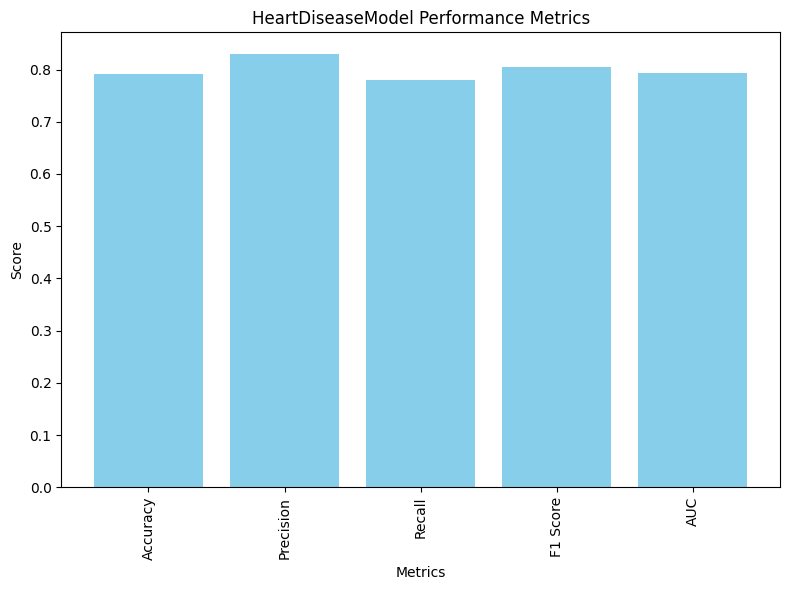

In [75]:
metrics = [accuracy, precision, recall, f1, auc]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
x = np.arange(len(metrics))

plt.figure(figsize=(8, 6))
plt.bar(x, metrics, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('HeartDiseaseModel Performance Metrics')
plt.xticks(x, labels, rotation='vertical')
plt.tight_layout()
plt.show()


# Testing Different Epochs (100 - 5000)

In [76]:
def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_logits = model(x_test_tensor)
        y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

    y_true = y_test_tensor.numpy().reshape(-1)

    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return confusion, accuracy, precision, recall, f1, auc


# Define model, loss function, and optimizer
model = HeartDiseaseModel(input_size=x_train_selected.shape[1], output_size=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# List of epochs to test using range
epochs_to_test = list(range(100, 5000, 200))

# Results dictionary to store metrics for each epoch
results = {}

for epochs in epochs_to_test:
    confusion, accuracy, precision, recall, f1, auc = train_and_evaluate_model(
        model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs
    )

    results[epochs] = {
        "confusion": confusion,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }

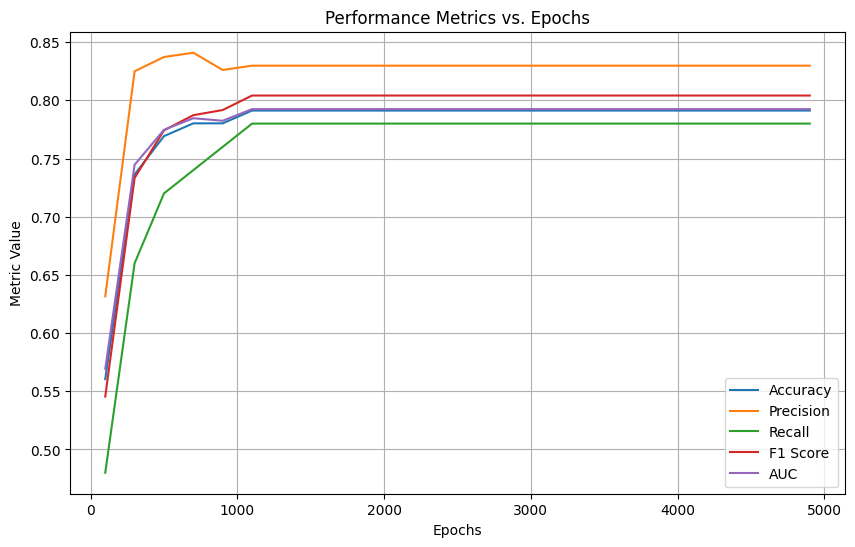

In [77]:
# Create lists to store metrics for plotting
accuracy_list = [metrics["accuracy"] for metrics in results.values()]
precision_list = [metrics["precision"] for metrics in results.values()]
recall_list = [metrics["recall"] for metrics in results.values()]
f1_list = [metrics["f1"] for metrics in results.values()]
auc_list = [metrics["auc"] for metrics in results.values()]

# Plotting the metrics
plt.figure(figsize=(10, 6))

plt.plot(epochs_to_test, accuracy_list, label='Accuracy')
plt.plot(epochs_to_test, precision_list, label='Precision')
plt.plot(epochs_to_test, recall_list, label='Recall')
plt.plot(epochs_to_test, f1_list, label='F1 Score')
plt.plot(epochs_to_test, auc_list, label='AUC')

plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


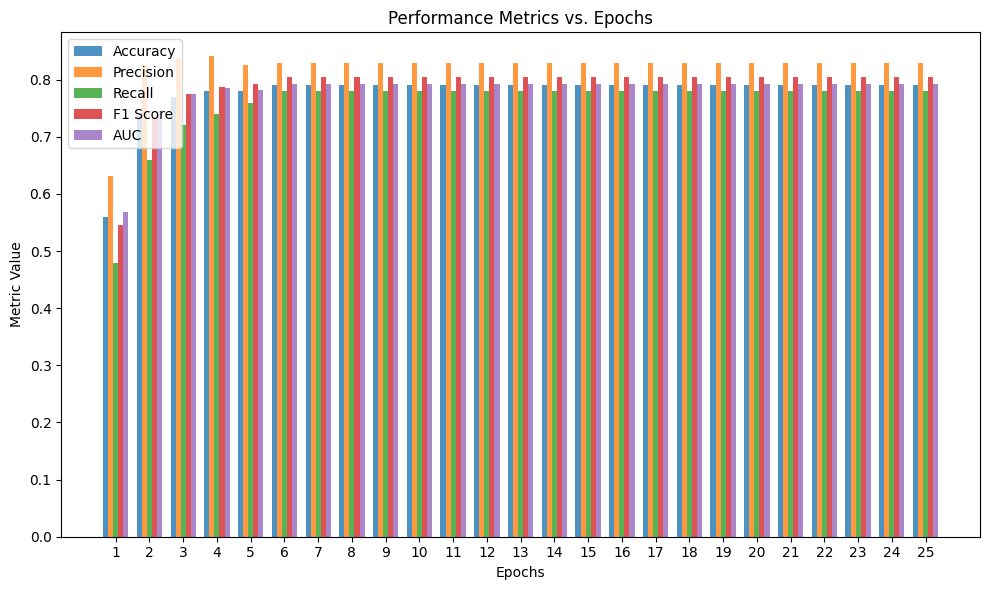

In [78]:
# Create lists to store metrics for plotting
accuracy_list = [metrics["accuracy"] for metrics in results.values()]
precision_list = [metrics["precision"] for metrics in results.values()]
recall_list = [metrics["recall"] for metrics in results.values()]
f1_list = [metrics["f1"] for metrics in results.values()]
auc_list = [metrics["auc"] for metrics in results.values()]
epochs_to_test = list(range(1, len(results) + 1))

# Plotting the metrics
plt.figure(figsize=(10, 6))

bar_width = 0.15
index = list(range(len(epochs_to_test)))

plt.bar(index, accuracy_list, bar_width, label='Accuracy', alpha=0.8)
plt.bar([i + bar_width for i in index], precision_list, bar_width, label='Precision', alpha=0.8)
plt.bar([i + 2 * bar_width for i in index], recall_list, bar_width, label='Recall', alpha=0.8)
plt.bar([i + 3 * bar_width for i in index], f1_list, bar_width, label='F1 Score', alpha=0.8)
plt.bar([i + 4 * bar_width for i in index], auc_list, bar_width, label='AUC', alpha=0.8)

plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Epochs')
plt.xticks([i + 2 * bar_width for i in index], epochs_to_test)
plt.legend()
plt.tight_layout()
plt.show()

In [79]:
def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    best_metrics = {
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1": 0,
        "auc": 0,
        "epoch": 0
    }

    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_logits = model(x_test_tensor)
            y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

        y_true = y_test_tensor.numpy().reshape(-1)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)

        # Check if this epoch has better metrics
        if accuracy > best_metrics["accuracy"]:
            best_metrics["accuracy"] = accuracy
            best_metrics["precision"] = precision
            best_metrics["recall"] = recall
            best_metrics["f1"] = f1
            best_metrics["auc"] = auc
            best_metrics["epoch"] = epoch

    return best_metrics


# Define model, loss function, and optimizer
model = HeartDiseaseModel(input_size=x_train_selected.shape[1], output_size=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# List of epochs to test using range
epochs_to_test = list(range(100, 5000, 200))

# Results dictionary to store metrics for each epoch
results = {}

for epochs in epochs_to_test:
    best_metrics = train_and_evaluate_model(
        model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs
    )

    results[epochs] = best_metrics

# Print results for each epoch
for epochs, metrics in results.items():
    print(f"Results for {epochs} epochs:")
    print("Best Epoch:", metrics["epoch"])
    print("Accuracy:", metrics["accuracy"])
    print("Precision:", metrics["precision"])
    print("Recall:", metrics["recall"])
    print("F1 Score:", metrics["f1"])
    print("AUC:", metrics["auc"])
    print("="*40)

Results for 100 epochs:
Best Epoch: 99
Accuracy: 0.43956043956043955
Precision: 0.49056603773584906
Recall: 0.52
F1 Score: 0.5048543689320388
AUC: 0.4307317073170731
Results for 300 epochs:
Best Epoch: 167
Accuracy: 0.8351648351648352
Precision: 0.8301886792452831
Recall: 0.88
F1 Score: 0.8543689320388349
AUC: 0.8302439024390244
Results for 500 epochs:
Best Epoch: 0
Accuracy: 0.7802197802197802
Precision: 0.7884615384615384
Recall: 0.82
F1 Score: 0.803921568627451
AUC: 0.7758536585365853
Results for 700 epochs:
Best Epoch: 0
Accuracy: 0.7692307692307693
Precision: 0.7959183673469388
Recall: 0.78
F1 Score: 0.7878787878787878
AUC: 0.7680487804878049
Results for 900 epochs:
Best Epoch: 815
Accuracy: 0.7692307692307693
Precision: 0.8222222222222222
Recall: 0.74
F1 Score: 0.7789473684210526
AUC: 0.7724390243902439
Results for 1100 epochs:
Best Epoch: 535
Accuracy: 0.7912087912087912
Precision: 0.8297872340425532
Recall: 0.78
F1 Score: 0.8041237113402062
AUC: 0.7924390243902439
Results for 1

# Expiremnting with amount of layers

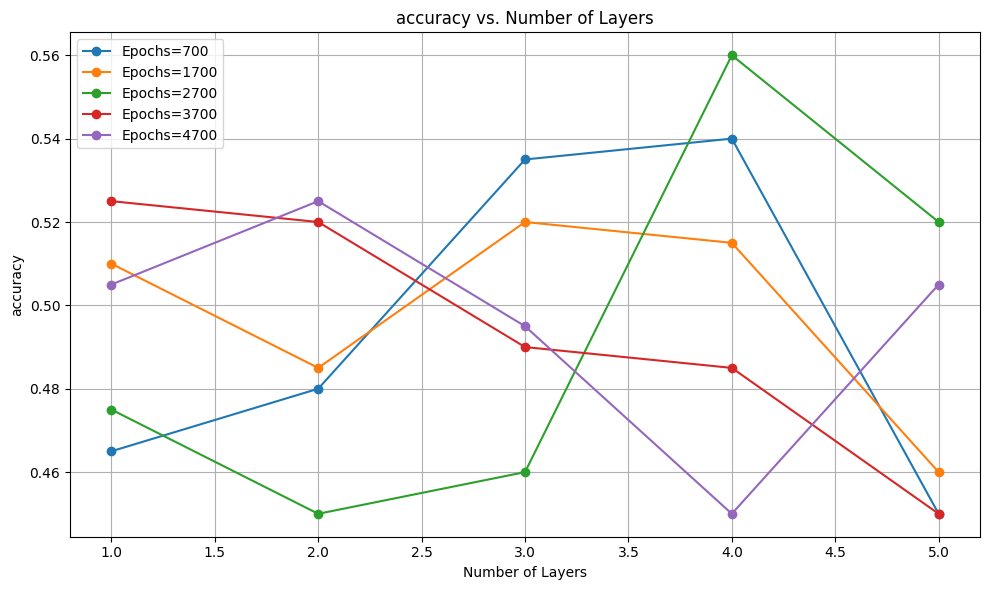

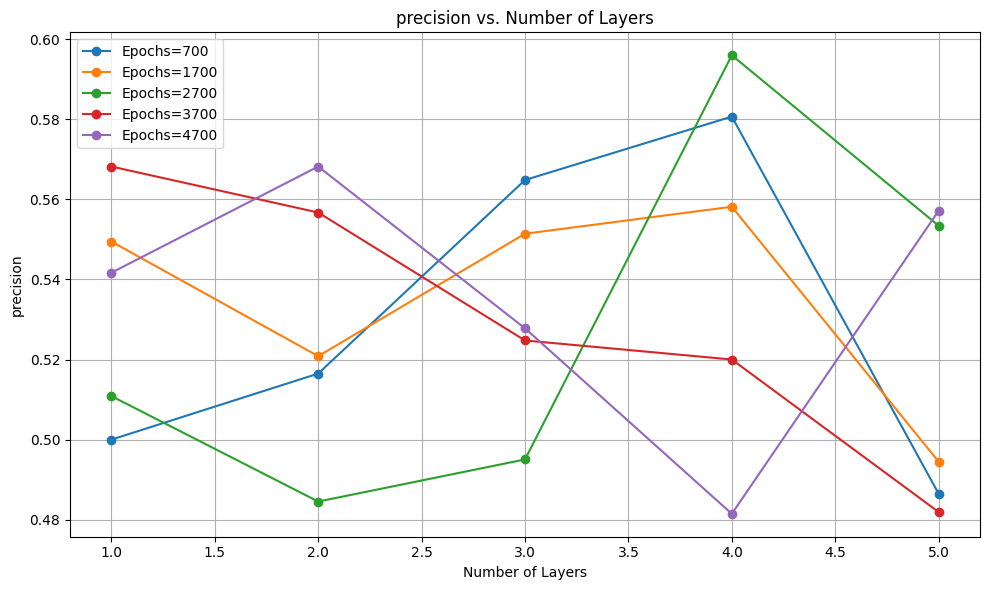

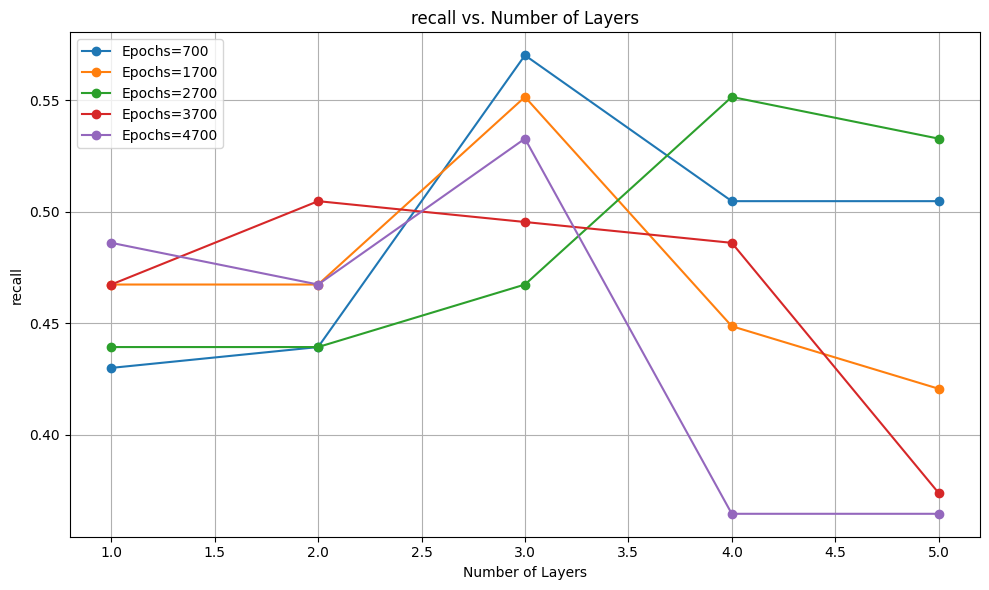

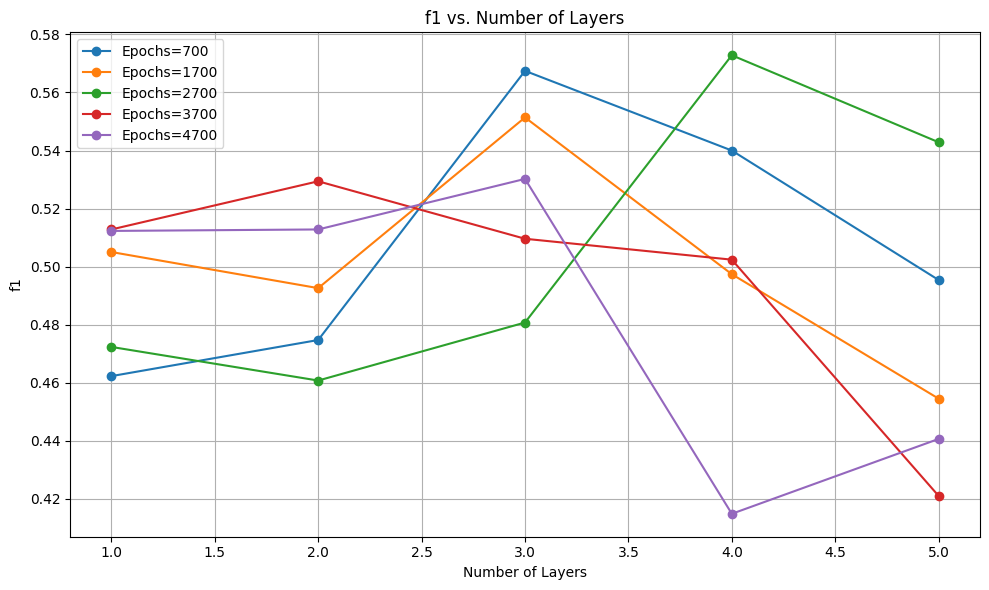

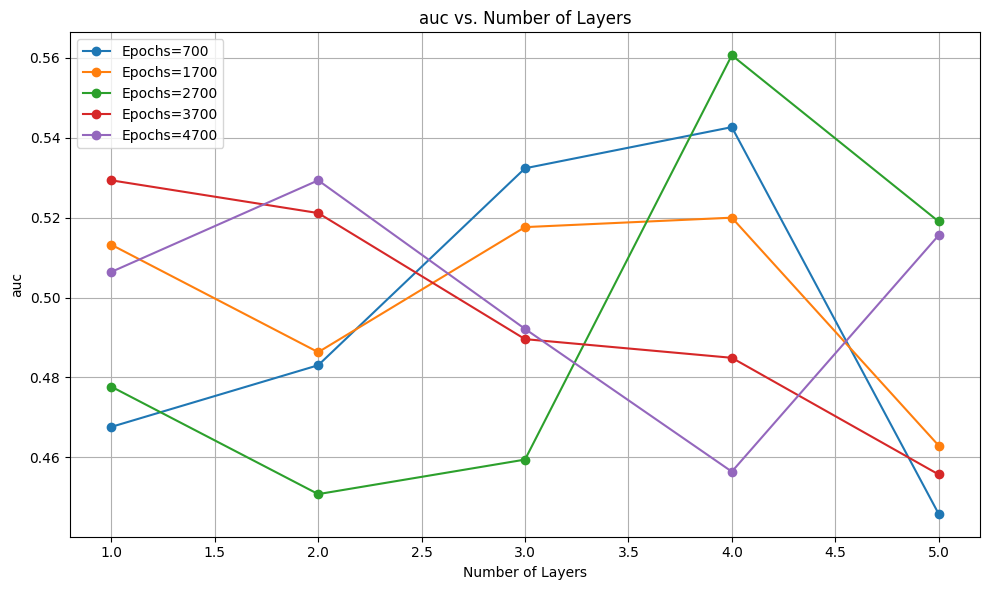

In [80]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, input_size) for _ in range(num_layers)])
        self.final_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = torch.relu(x)
        x = self.final_layer(x)
        return x

def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_logits = model(x_test_tensor)
        y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

    y_true = y_test_tensor.numpy().reshape(-1)

    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return confusion, accuracy, precision, recall, f1, auc

# Create sample data
np.random.seed(0)
x_train_selected = np.random.rand(1000, 10)
y_train = np.random.randint(0, 2, 1000)
x_test_selected = np.random.rand(200, 10)
y_test = np.random.randint(0, 2, 200)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# List of number of layers and epochs to test
num_layers_list = [1, 2, 3, 4, 5]
epochs_list = [700, 1700, 2700, 3700, 4700]

# Results dictionaries to store metrics for each configuration
results_layers = {}
results_epochs = {}

# Evaluate with different numbers of layers at each specified epoch
for epoch in epochs_list:
    for num_layers in num_layers_list:
        model = HeartDiseaseModel(input_size=x_train_selected.shape[1], output_size=1, num_layers=num_layers)
        loss_fn = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Train and evaluate the model
        confusion, accuracy, precision, recall, f1, auc = train_and_evaluate_model(
            model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epoch
        )

        results_epochs.setdefault(epoch, {}).setdefault(num_layers, {
            "confusion": confusion,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc
        })

# Function to display results
def plot_results(results_dict, metric):
    plt.figure(figsize=(10, 6))
    for num_layers, metrics in results_dict.items():
        x = list(metrics.keys())
        y = [metric_result[metric] for metric_result in metrics.values()]
        plt.plot(x, y, marker='o', label=f'Epochs={num_layers}')

    plt.xlabel('Number of Layers')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Number of Layers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot results for different metrics
for metric in ["accuracy", "precision", "recall", "f1", "auc"]:
    plot_results(results_epochs, metric)


In [81]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x

def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_logits = model(x_test_tensor)
        y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

    y_true = y_test_tensor.numpy().reshape(-1)

    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return confusion, accuracy, precision, recall, f1, auc

# Define your model, loss function, and optimizer
input_size = x_train_selected.shape[1]
output_size = 1
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# List of number of layers and epochs to test
num_layers_list = [1, 2, 3, 4, 5]
epochs_list = [700, 1700, 2700, 3700, 4700]

# Results dictionaries to store metrics for each configuration
results_layers = {}
results_epochs = {}

# Evaluate with different numbers of layers at each specified epoch
for epoch in epochs_list:
    for num_layers in num_layers_list:
        model = HeartDiseaseModel(input_size, output_size)
        optimizer_instance = optimizer(model.parameters(), lr=0.001)

        # Train and evaluate the model
        confusion, accuracy, precision, recall, f1, auc = train_and_evaluate_model(
            model, loss_fn, optimizer_instance, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epoch
        )

        results_epochs.setdefault(epoch, {}).setdefault(num_layers, {
            "confusion": confusion,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc
        })

# Function to display results
def display_results(results_dict, title):
    print(f"### {title}")
    print("Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC")
    print("---------------------------------------------------------------")
    for num_layers, metrics in results_dict.items():
        row = f"{num_layers:<16}"
        for metric, value in metrics.items():
            if isinstance(value, float):
                row += f"{value:.4f} | "
            else:
                row += f"{value} | "
        print(row[:-2])

# Display results for different numbers of layers
display_results(results_layers, "Model Performance with Varying Number of Layers")
print()

# Display results for different numbers of epochs
display_results(results_epochs, "Model Performance with Varying Number of Epochs")



### Model Performance with Varying Number of Layers
Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC
---------------------------------------------------------------

### Model Performance with Varying Number of Epochs
Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC
---------------------------------------------------------------
700             {'confusion': array([[71, 22],
       [79, 28]]), 'accuracy': 0.495, 'precision': 0.56, 'recall': 0.2616822429906542, 'f1': 0.35668789808917195, 'auc': 0.512561551602854} | {'confusion': array([[76, 17],
       [81, 26]]), 'accuracy': 0.51, 'precision': 0.6046511627906976, 'recall': 0.24299065420560748, 'f1': 0.3466666666666667, 'auc': 0.5300974776404381} | {'confusion': array([[71, 22],
       [82, 25]]), 'accuracy': 0.48, 'precision': 0.5319148936170213, 'recall': 0.2336448598130841, 'f1': 0.3246753246753247, 'auc': 0.4985428600140689} | {'confusion': array([[69, 24],
       [78, 29]]), 'accuracy': 0.49, 'prec

In [82]:
def display_results(results_dict, title):
    print(f"### {title}")
    print("Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC")
    print("---------------------------------------------------------------")
    for num_layers, metrics in results_dict.items():
        row = f"{num_layers:<16}"
        for metric, value in metrics.items():
            if isinstance(value, float):
                row += f"{value:.4f} | "
            else:
                row += f"{value} | "
        print(row[:-2])

# Display results for different numbers of layers
display_results(results_layers, "Model Performance with Varying Number of Layers")
print()

# Display results for different numbers of epochs
display_results(results_epochs, "Model Performance with Varying Number of Epochs")



### Model Performance with Varying Number of Layers
Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC
---------------------------------------------------------------

### Model Performance with Varying Number of Epochs
Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC
---------------------------------------------------------------
700             {'confusion': array([[71, 22],
       [79, 28]]), 'accuracy': 0.495, 'precision': 0.56, 'recall': 0.2616822429906542, 'f1': 0.35668789808917195, 'auc': 0.512561551602854} | {'confusion': array([[76, 17],
       [81, 26]]), 'accuracy': 0.51, 'precision': 0.6046511627906976, 'recall': 0.24299065420560748, 'f1': 0.3466666666666667, 'auc': 0.5300974776404381} | {'confusion': array([[71, 22],
       [82, 25]]), 'accuracy': 0.48, 'precision': 0.5319148936170213, 'recall': 0.2336448598130841, 'f1': 0.3246753246753247, 'auc': 0.4985428600140689} | {'confusion': array([[69, 24],
       [78, 29]]), 'accuracy': 0.49, 'prec

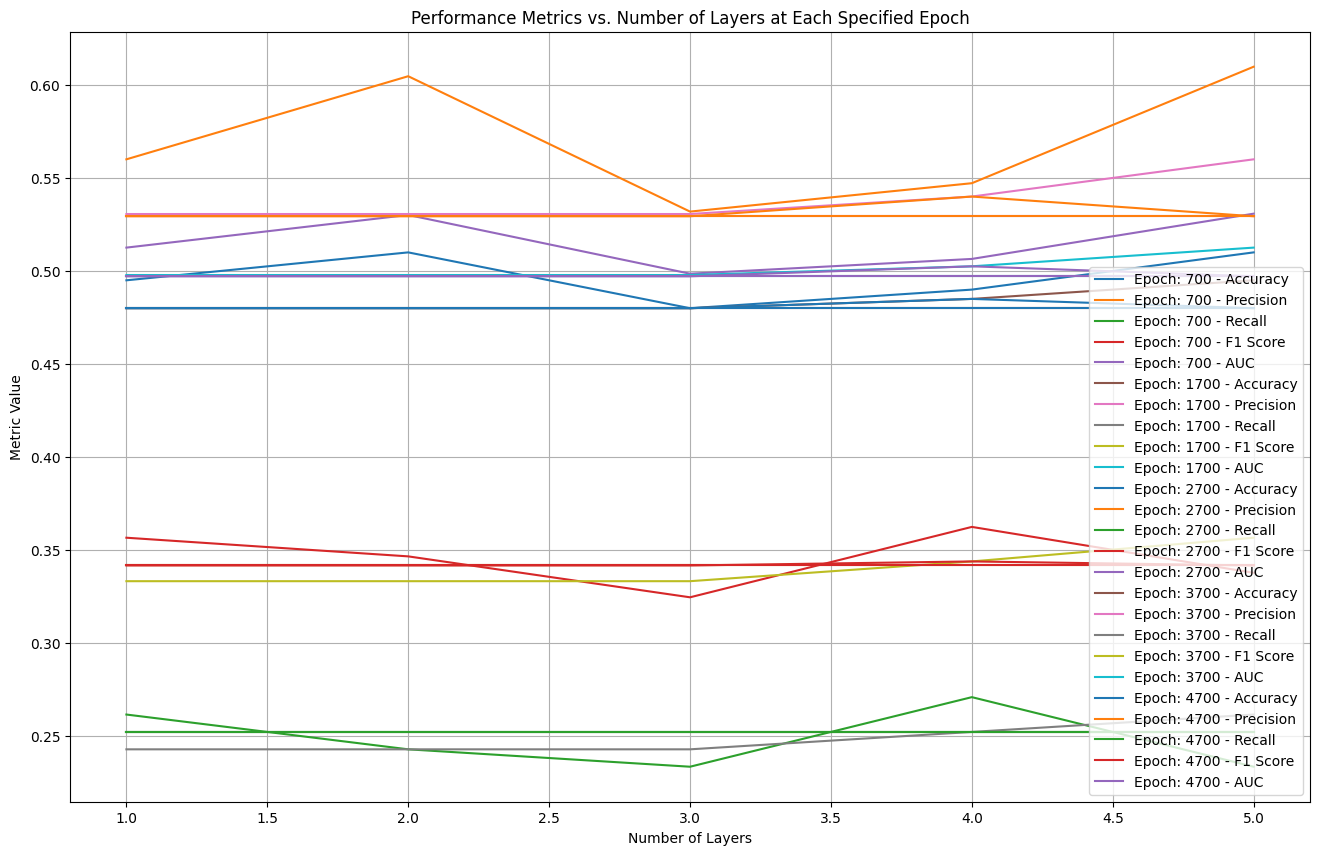

In [83]:
# Print and plot results for different numbers of layers at each specified epoch
plt.figure(figsize=(16, 10))

for epoch, layers_dict in results_epochs.items():
    accuracy_list = [metrics["accuracy"] for metrics in layers_dict.values()]
    precision_list = [metrics["precision"] for metrics in layers_dict.values()]
    recall_list = [metrics["recall"] for metrics in layers_dict.values()]
    f1_list = [metrics["f1"] for metrics in layers_dict.values()]
    auc_list = [metrics["auc"] for metrics in layers_dict.values()]

    plt.plot(num_layers_list, accuracy_list, label=f'Epoch: {epoch} - Accuracy')
    plt.plot(num_layers_list, precision_list, label=f'Epoch: {epoch} - Precision')
    plt.plot(num_layers_list, recall_list, label=f'Epoch: {epoch} - Recall')
    plt.plot(num_layers_list, f1_list, label=f'Epoch: {epoch} - F1 Score')
    plt.plot(num_layers_list, auc_list, label=f'Epoch: {epoch} - AUC')

plt.xlabel('Number of Layers')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Number of Layers at Each Specified Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Changing Number of units/neurons in each layer

In [84]:
class CustomModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_neurons):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, num_neurons))  # First layer
        for _ in range(num_layers - 1):  # Additional hidden layers
            self.layers.append(nn.Linear(num_neurons, num_neurons))
        self.final_layer = nn.Linear(num_neurons, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = torch.relu(x)
        x = self.final_layer(x)
        return x

def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_logits = model(x_test_tensor)
        y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

    y_true = y_test_tensor.numpy().reshape(-1)

    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return confusion, accuracy, precision, recall, f1, auc

# Define your model, loss function, and optimizer
input_size = x_train_selected.shape[1]
output_size = 1
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# List of number of neurons and epochs to test
num_neurons_list = list(range(6, 101, 4))
epochs = 700
num_layers = 3  # Fixed number of layers for this example

# Results dictionaries to store metrics for each configuration
results_neurons = {}

# Evaluate with different numbers of neurons in each layer
for num_neurons in num_neurons_list:
    model = CustomModel(input_size, output_size, num_layers, num_neurons)
    optimizer_instance = optimizer(model.parameters(), lr=0.001)

    # Train and evaluate the model
    confusion, accuracy, precision, recall, f1, auc = train_and_evaluate_model(
        model, loss_fn, optimizer_instance, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs
    )

    results_neurons[num_neurons] = {
        "confusion": confusion,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }

# Print results for each number of neurons in each layer
for num_neurons, metrics in results_neurons.items():
    print(f"Results for {num_neurons} neurons in each layer:")
    print("Confusion Matrix:")
    print(metrics["confusion"])
    print("Accuracy:", metrics["accuracy"])
    print("Precision:", metrics["precision"])
    print("Recall:", metrics["recall"])
    print("F1 Score:", metrics["f1"])
    print("AUC:", metrics["auc"])
    print("="*40)


Results for 6 neurons in each layer:
Confusion Matrix:
[[36 57]
 [45 62]]
Accuracy: 0.49
Precision: 0.5210084033613446
Recall: 0.5794392523364486
F1 Score: 0.5486725663716815
AUC: 0.48326801326499846
Results for 10 neurons in each layer:
Confusion Matrix:
[[45 48]
 [61 46]]
Accuracy: 0.455
Precision: 0.48936170212765956
Recall: 0.42990654205607476
F1 Score: 0.4577114427860696
AUC: 0.45688875489900516
Results for 14 neurons in each layer:
Confusion Matrix:
[[44 49]
 [60 47]]
Accuracy: 0.455
Precision: 0.4895833333333333
Recall: 0.4392523364485981
F1 Score: 0.4630541871921182
AUC: 0.4561853080092453
Results for 18 neurons in each layer:
Confusion Matrix:
[[49 44]
 [65 42]]
Accuracy: 0.455
Precision: 0.4883720930232558
Recall: 0.3925233644859813
F1 Score: 0.4352331606217616
AUC: 0.4597025424580444
Results for 22 neurons in each layer:
Confusion Matrix:
[[53 40]
 [53 54]]
Accuracy: 0.535
Precision: 0.574468085106383
Recall: 0.5046728971962616
F1 Score: 0.5373134328358209
AUC: 0.53728268515

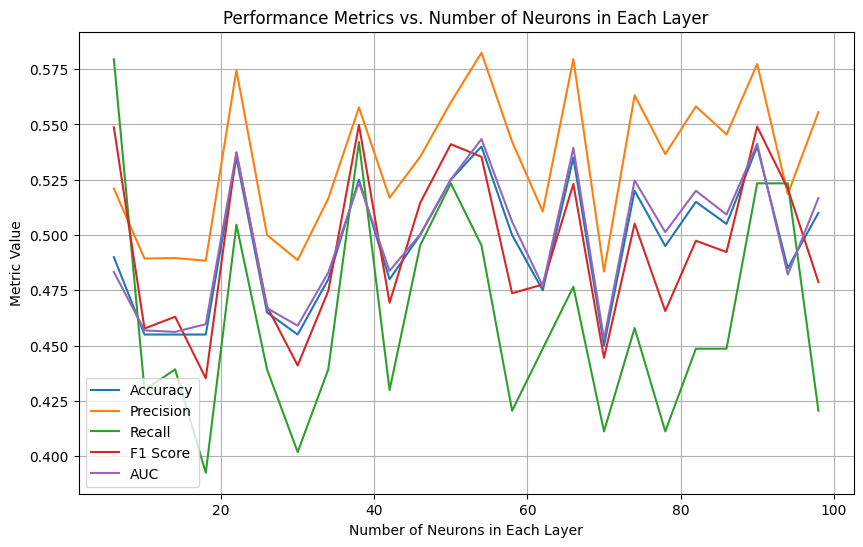

In [85]:
# Extracting metrics for plotting
accuracy_list = [metrics["accuracy"] for num_neurons, metrics in results_neurons.items()]
precision_list = [metrics["precision"] for num_neurons, metrics in results_neurons.items()]
recall_list = [metrics["recall"] for num_neurons, metrics in results_neurons.items()]
f1_list = [metrics["f1"] for num_neurons, metrics in results_neurons.items()]
auc_list = [metrics["auc"] for num_neurons, metrics in results_neurons.items()]

# Plotting the metrics for different numbers of neurons in each layer
plt.figure(figsize=(10, 6))

plt.plot(num_neurons_list, accuracy_list, label='Accuracy')
plt.plot(num_neurons_list, precision_list, label='Precision')
plt.plot(num_neurons_list, recall_list, label='Recall')
plt.plot(num_neurons_list, f1_list, label='F1 Score')
plt.plot(num_neurons_list, auc_list, label='AUC')

plt.xlabel('Number of Neurons in Each Layer')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Number of Neurons in Each Layer')
plt.legend()
plt.grid(True)
plt.show()

# Changing Activation Functions

In [86]:
# Define the custom neural network class
class CustomModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_neurons, activations):
        super().__init__()
        self.layers = nn.ModuleList()
        self.activations = activations
        self.layers.append(nn.Linear(input_size, num_neurons))  # First layer
        for _ in range(num_layers - 1):  # Additional hidden layers
            self.layers.append(nn.Linear(num_neurons, num_neurons))
        self.final_layer = nn.Linear(num_neurons, output_size)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                activation_fn = self.activations[i]
                x = activation_fn(x)
        x = self.final_layer(x)
        return x

# Function to train and evaluate the model
def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_logits = model(x_test_tensor)
        y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

    y_true = y_test_tensor.numpy().reshape(-1)

    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return confusion, accuracy, precision, recall, f1, auc

# Create sample data
np.random.seed(0)
x_train_selected = np.random.rand(1000, 10)
y_train = np.random.randint(0, 2, 1000)
x_test_selected = np.random.rand(200, 10)
y_test = np.random.randint(0, 2, 200)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the activation functions for each run
activation_functions = [
    [nn.ReLU() for _ in range(3)],  # All ReLU
    [nn.Tanh() for _ in range(3)],  # All Tanh
    [nn.LeakyReLU(0.1) for _ in range(3)],  # All Leaky ReLU
    [nn.ELU() for _ in range(3)],  # All ELU
    [nn.ReLU(), nn.Tanh(), nn.LeakyReLU(0.1)],  # Mixed activation functions
    [nn.Sigmoid() for _ in range(3)]  # All Sigmoid
]

# Define your model, loss function, and optimizer
input_size = x_train_selected.shape[1]
output_size = 1
num_neurons = 64
epochs = 700

# Results dictionary to store metrics for each configuration
results = {}

# Loop through each set of activation functions
for i, activations in enumerate(activation_functions):
    model = CustomModel(input_size, output_size, len(activations), num_neurons, activations)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train and evaluate the model
    confusion, accuracy, precision, recall, f1, auc = train_and_evaluate_model(
        model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs
    )

    # Store the results
    results[f"Run {i+1}"] = {
        "Activation Functions": [act.__class__.__name__ for act in activations],
        "Confusion Matrix": confusion,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc
    }

# Print and compare the results
for key, value in results.items():
    print(f"Results for {key}:")
    print("Activation Functions:", value["Activation Functions"])
    print("Confusion Matrix:")
    print(value["Confusion Matrix"])
    print("Accuracy:", value["Accuracy"])
    print("Precision:", value["Precision"])
    print("Recall:", value["Recall"])
    print("F1 Score:", value["F1 Score"])
    print("AUC:", value["AUC"])
    print("="*50)

Results for Run 1:
Activation Functions: ['ReLU', 'ReLU', 'ReLU']
Confusion Matrix:
[[48 45]
 [61 46]]
Accuracy: 0.47
Precision: 0.5054945054945055
Recall: 0.42990654205607476
F1 Score: 0.46464646464646464
AUC: 0.4730177871570696
Results for Run 2:
Activation Functions: ['Tanh', 'Tanh', 'Tanh']
Confusion Matrix:
[[44 49]
 [57 50]]
Accuracy: 0.47
Precision: 0.5050505050505051
Recall: 0.4672897196261682
F1 Score: 0.48543689320388356
AUC: 0.4702039995980304
Results for Run 3:
Activation Functions: ['LeakyReLU', 'LeakyReLU', 'LeakyReLU']
Confusion Matrix:
[[51 42]
 [64 43]]
Accuracy: 0.47
Precision: 0.5058823529411764
Recall: 0.40186915887850466
F1 Score: 0.4479166666666667
AUC: 0.47512812782634906
Results for Run 4:
Activation Functions: ['ELU', 'ELU', 'ELU']
Confusion Matrix:
[[57 36]
 [67 40]]
Accuracy: 0.485
Precision: 0.5263157894736842
Recall: 0.37383177570093457
F1 Score: 0.4371584699453552
AUC: 0.4933675007536931
Results for Run 5:
Activation Functions: ['ReLU', 'Tanh', 'LeakyReLU'

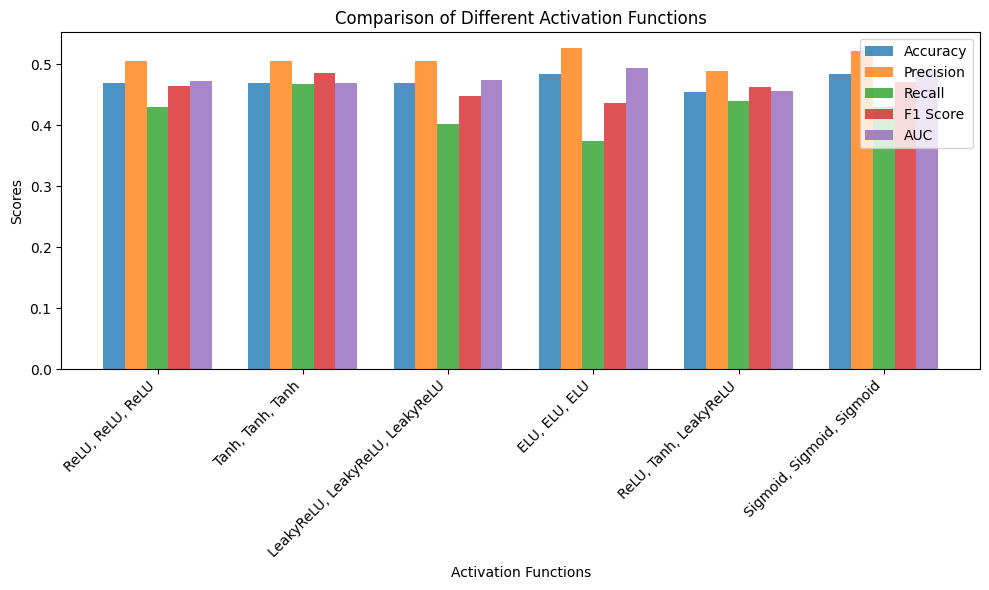

In [87]:
# Extracting metrics for plotting
activation_labels = [', '.join(result["Activation Functions"]) for result in results.values()]
accuracy_scores = [result["Accuracy"] for result in results.values()]
precision_scores = [result["Precision"] for result in results.values()]
recall_scores = [result["Recall"] for result in results.values()]
f1_scores = [result["F1 Score"] for result in results.values()]
auc_scores = [result["AUC"] for result in results.values()]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(results))

ax.bar(x, accuracy_scores, width=0.15, label='Accuracy', align='center', alpha=0.8)
ax.bar([i + 0.15 for i in x], precision_scores, width=0.15, label='Precision', align='center', alpha=0.8)
ax.bar([i + 0.3 for i in x], recall_scores, width=0.15, label='Recall', align='center', alpha=0.8)
ax.bar([i + 0.45 for i in x], f1_scores, width=0.15, label='F1 Score', align='center', alpha=0.8)
ax.bar([i + 0.6 for i in x], auc_scores, width=0.15, label='AUC', align='center', alpha=0.8)

ax.set_xticks([i + 0.3 for i in x])
ax.set_xticklabels(activation_labels, rotation=45, ha='right')

ax.set_xlabel('Activation Functions')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Different Activation Functions')
ax.legend()

plt.tight_layout()
plt.show()

## NO Feature selection
## Train/test data split before scaling (Min/max and z-score normalization)


In [88]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import sklearn.metrics
import torch
import torch.optim as optim
from torch import nn
import time
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [89]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [90]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

Loading the Data

In [91]:
df = pd.read_csv("heart_data.csv")
df

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2       1  
2        2   0     2       1  
3        2   0     2       1  
4        2   0     2       1  
..     ...  ..   ...     ...  
298      1   0     3       0  
299      1   0     3       0  
300      1   2     3       0  
301      1   1     3       0  
302      1   1     2       0  

[303 rows x 14 columns]

# Data Exploration

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Exploring more information about the target variable

In [93]:
# Splitting the data into a positive target and a negative target
hdpositive = df.loc[df['target']== 1, ['target','age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]
hdpositive

target  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
0         1   63    1   3       145   233    1        0      150      0   
1         1   37    1   2       130   250    0        1      187      0   
2         1   41    0   1       130   204    0        0      172      0   
3         1   56    1   1       120   236    0        1      178      0   
4         1   57    0   0       120   354    0        1      163      1   
..      ...  ...  ...  ..       ...   ...  ...      ...      ...    ...   
160       1   56    1   1       120   240    0        1      169      0   
161       1   55    0   1       132   342    0        1      166      0   
162       1   41    1   1       120   157    0        1      182      0   
163       1   38    1   2       138   175    0        1      173      0   
164       1   38    1   2       138   175    0        1      173      0   

     oldpeak  slope  ca  thal  
0        2.3      0   0     1  
1        3.5      0   0     2  
2        1.4      2   0     2  
3        0.8      2   0     2  
4        0.6      2   0     2  
..       ...    ...  ..   ...  
160      0.0      0   0     2  
161      1.2      2   0     2  
162      0.0      2   0     2  
163      0.0      2   4     2  
164      0.0      2   4     2  

[165 rows x 14 columns]

In [94]:
# Splitting the data into a positive target and a negative target
hdnegative = df.loc[df['target']== 0, ['target','age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]
hdnegative

target  age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  \
165       0   67    1   0       160   286    0        0      108      1   
166       0   67    1   0       120   229    0        0      129      1   
167       0   62    0   0       140   268    0        0      160      0   
168       0   63    1   0       130   254    0        0      147      0   
169       0   53    1   0       140   203    1        0      155      1   
..      ...  ...  ...  ..       ...   ...  ...      ...      ...    ...   
298       0   57    0   0       140   241    0        1      123      1   
299       0   45    1   3       110   264    0        1      132      0   
300       0   68    1   0       144   193    1        1      141      0   
301       0   57    1   0       130   131    0        1      115      1   
302       0   57    0   1       130   236    0        0      174      0   

     oldpeak  slope  ca  thal  
165      1.5      1   3     2  
166      2.6      1   2     3  
167      3.6      0   2     2  
168      1.4      1   1     3  
169      3.1      0   0     3  
..       ...    ...  ..   ...  
298      0.2      1   0     3  
299      1.2      1   0     3  
300      3.4      1   2     3  
301      1.2      1   1     3  
302      0.0      1   1     2  

[138 rows x 14 columns]

In [95]:
df['target'].describe()

count    303.000000
mean       0.544554
std        0.498835
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: target, dtype: float64

In [96]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

<Axes: xlabel='target', ylabel='Density'>

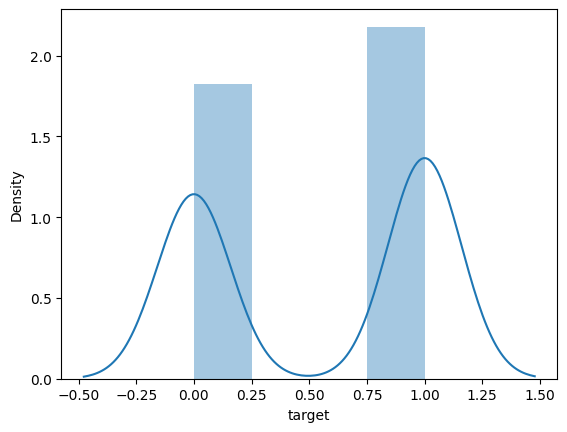

In [97]:
sns.distplot(df['target'])

In [98]:
print("Skewness: %f" % df['target'].skew())
print("Kurtosis: %f" % df['target'].kurt())

Skewness: -0.179821
Kurtosis: -1.980783


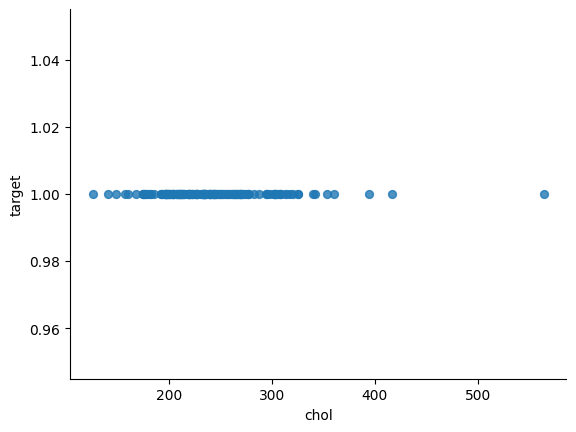

In [99]:
# @title heart disease vs chol - positive
# Looking at the posssible correlation between heart disease and cholestorol
hdpositive.plot(kind='scatter', x='chol', y='target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [100]:
hdpositive['chol'].describe()

count    165.000000
mean     242.230303
std       53.552872
min      126.000000
25%      208.000000
50%      234.000000
75%      267.000000
max      564.000000
Name: chol, dtype: float64

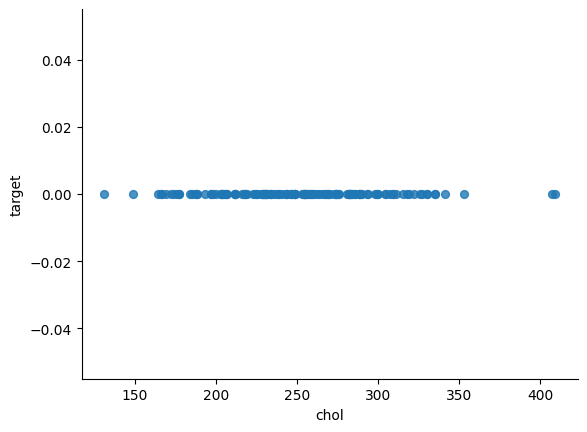

In [101]:
# @title heart disease vs chol - negative
# Looking at the posssible correlation between an absence of heart disease and cholestorol
hdnegative.plot(kind='scatter', x='chol', y='target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [102]:
hdnegative['chol'].describe()

count    138.000000
mean     251.086957
std       49.454614
min      131.000000
25%      217.250000
50%      249.000000
75%      283.000000
max      409.000000
Name: chol, dtype: float64

In [103]:
hdnegative['chol'].median()

249.0

Conclusion:
The higher cholestorol for negative vs. positive proves the need for data normalization (which will be done in the next step - cleaning and preprocessing)

In [104]:
# @title Correlation Matrix
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach','exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
correlations = df.corr()
print (correlations)

               age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.098447 -0.068653  0.279351  0.213678  0.121308   
sex      -0.098447  1.000000 -0.049353 -0.056769 -0.197912  0.045032   
cp       -0.068653 -0.049353  1.000000  0.047608 -0.076904  0.094444   
trestbps  0.279351 -0.056769  0.047608  1.000000  0.123174  0.177531   
chol      0.213678 -0.197912 -0.076904  0.123174  1.000000  0.013294   
fbs       0.121308  0.045032  0.094444  0.177531  0.013294  1.000000   
restecg  -0.116211 -0.058196  0.044421 -0.114103 -0.151040 -0.084189   
thalach  -0.398522 -0.044020  0.295762 -0.046698 -0.009940 -0.008567   
exang     0.096801  0.141664 -0.394280  0.067616  0.067023  0.025665   
oldpeak   0.210013  0.096093 -0.149230  0.193216  0.053952  0.005747   
slope    -0.168814 -0.030711  0.119717 -0.121475 -0.004038 -0.059894   
ca        0.276326  0.118261 -0.181053  0.101389  0.070511  0.137979   
thal      0.068001  0.210041 -0.161736  0.062210  0.098803 -0.03

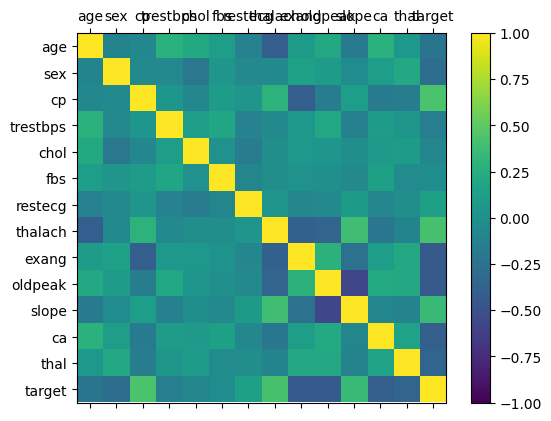

In [105]:
# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,30)))
cax = ax.matshow(correlations, interpolation='nearest', vmin = -1, vmax = 1)
fig.colorbar(cax)
ticks = np.arange(0, 14, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(columns)
ax.set_yticklabels(columns)
plt.show()

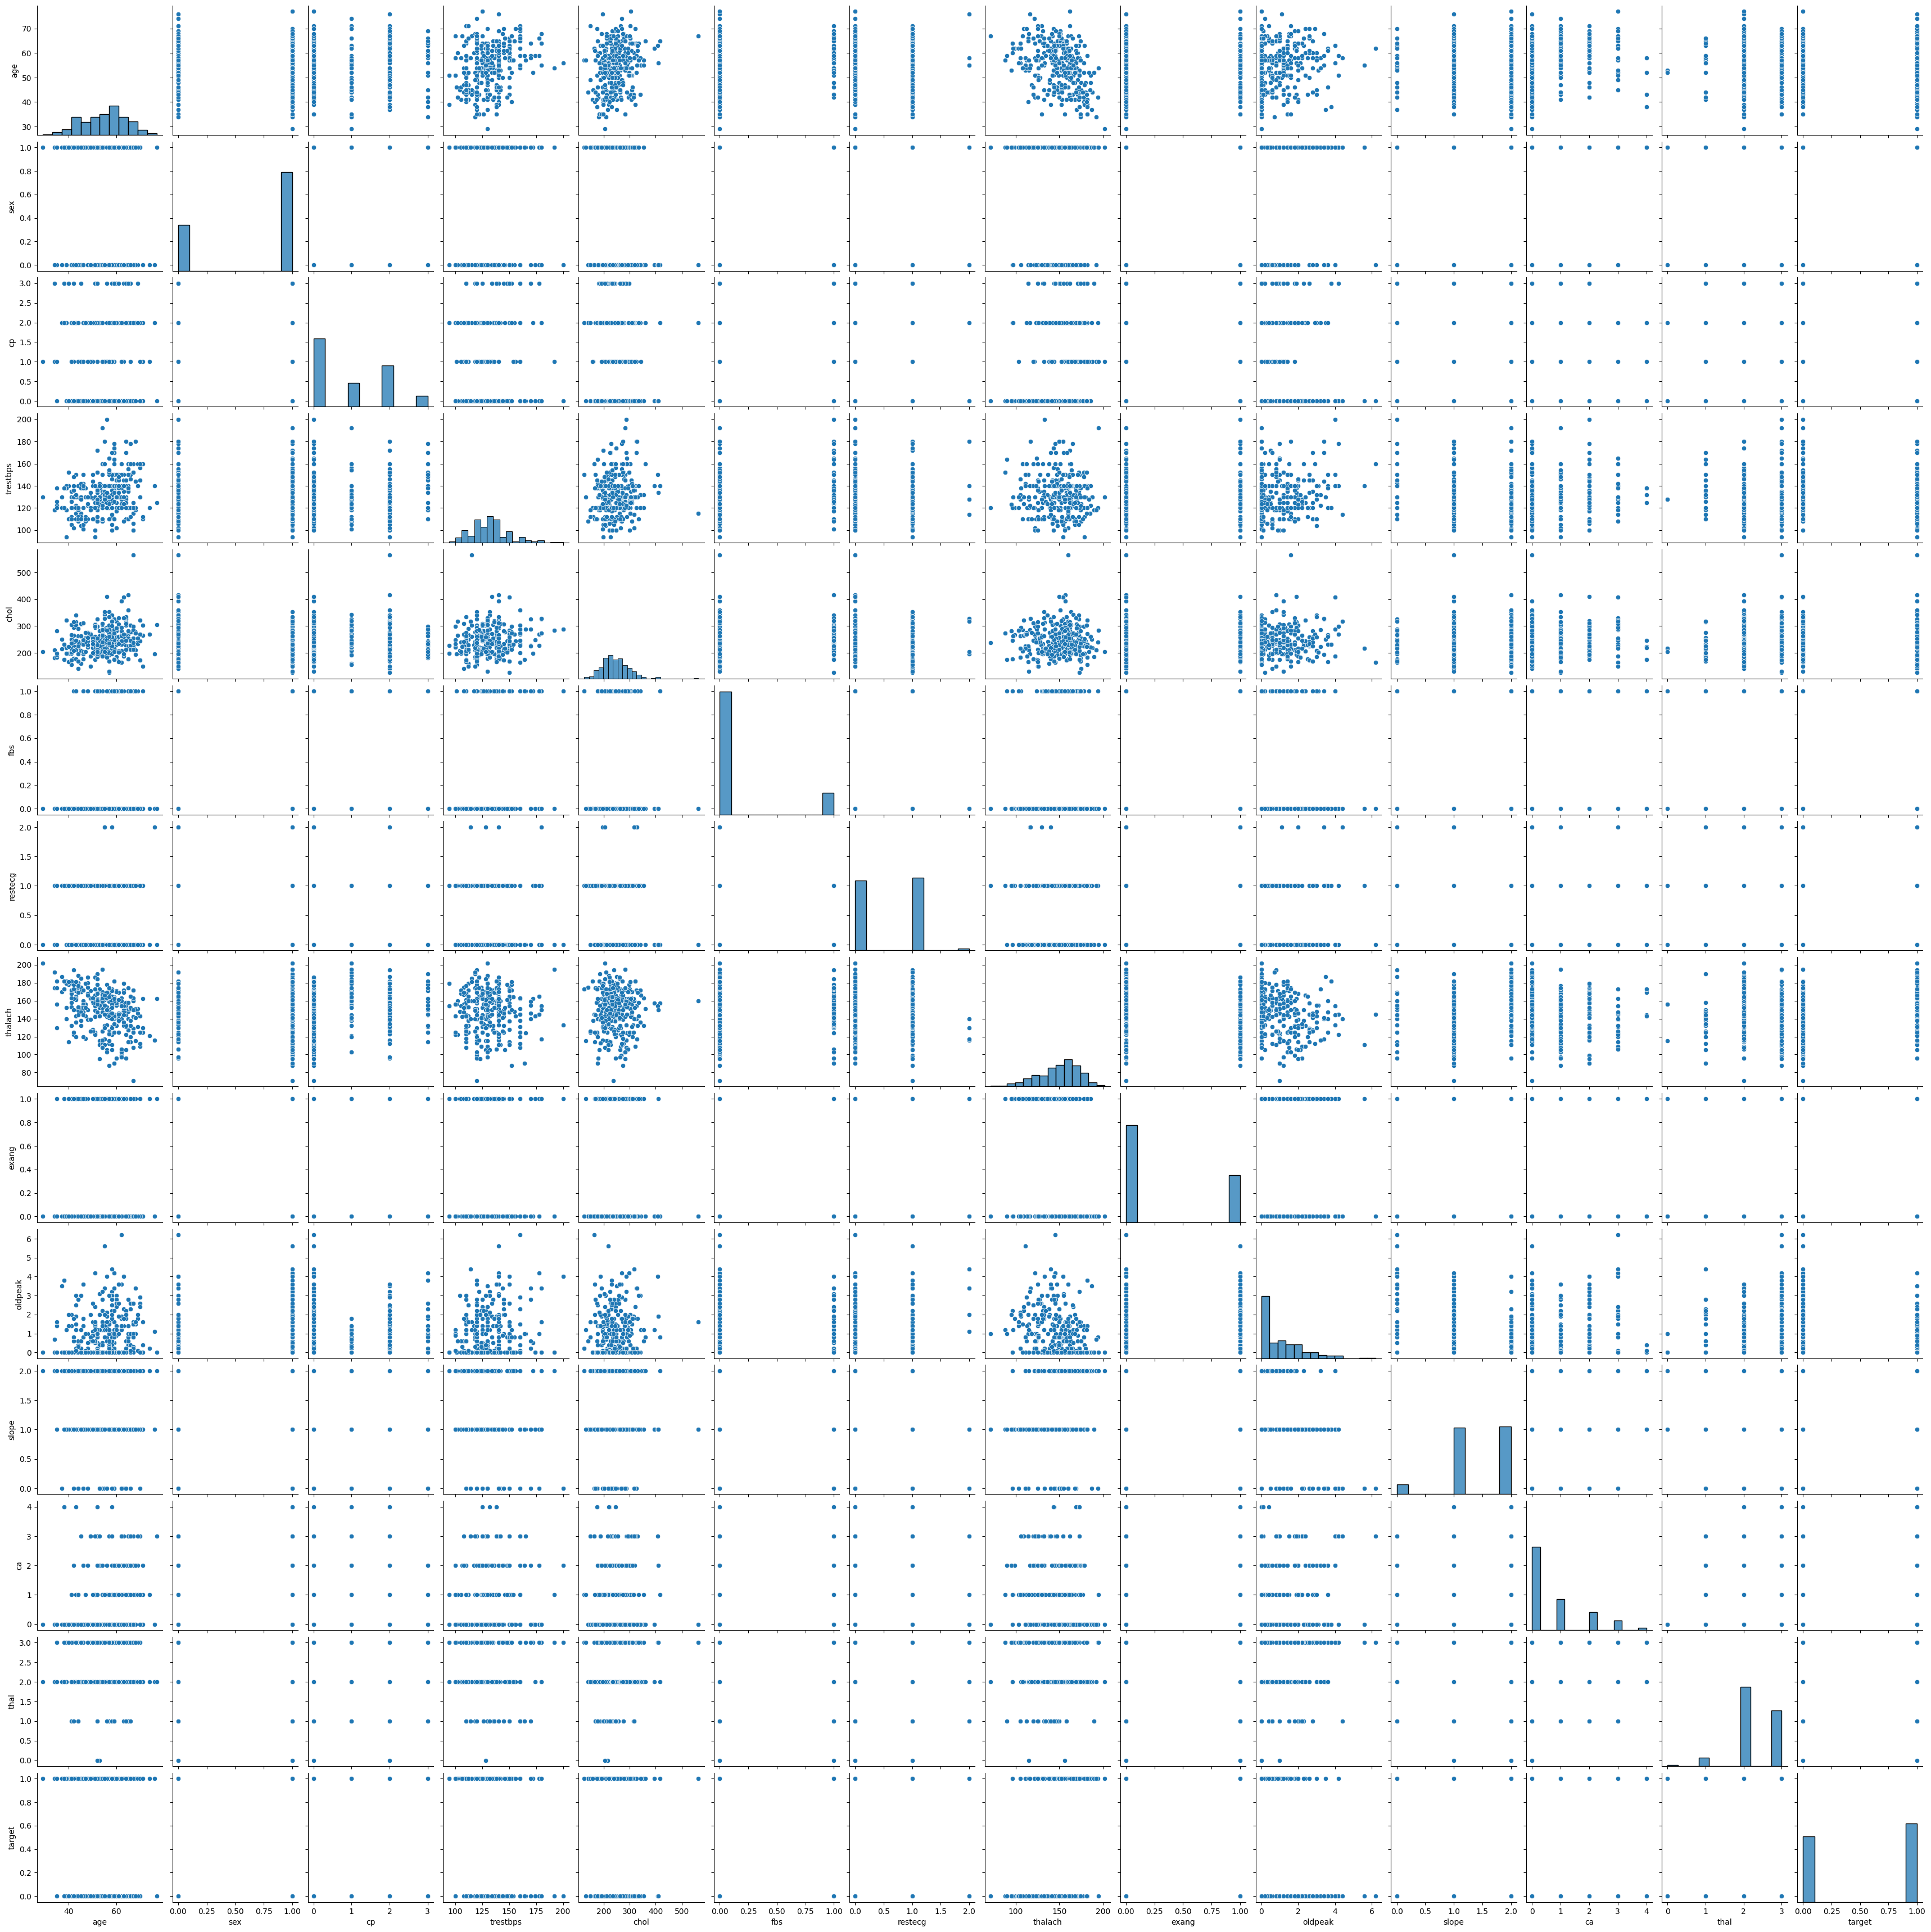

In [106]:
sns.pairplot(df)

<Axes: ylabel='Density'>

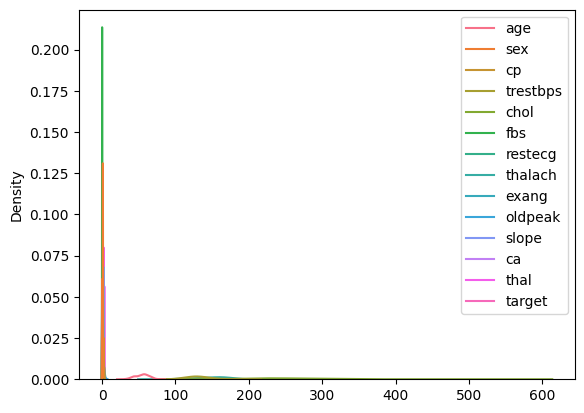

In [107]:
sns.kdeplot(df)

In [108]:
df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1

# Data Preprocessing

In [109]:
# Load the data
data = pd.read_csv('heart_data.csv')

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values)

# Calculate quartiles and IQR for 'trestbps', 'chol', 'thalach', and 'oldpeak'
Q1 = data[['trestbps', 'chol', 'thalach', 'oldpeak']].quantile(0.25)
Q3 = data[['trestbps', 'chol', 'thalach', 'oldpeak']].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers using IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers in 'trestbps', 'chol', 'thalach', and 'oldpeak'
outliers = ((data[['trestbps', 'chol', 'thalach', 'oldpeak']] < lower_bound) | (data[['trestbps', 'chol', 'thalach', 'oldpeak']] > upper_bound)).any(axis=1)

# Filter the dataset to remove outliers
data = data[~outliers]

# Calculate the average for each attribute
average_values = data[['trestbps', 'chol', 'thalach', 'oldpeak']].mean()
print("Average values for each attribute:")
print(average_values)

# Cap the outliers that are outside of the normal bounds
data['trestbps'] = data['trestbps'].clip(lower=lower_bound['trestbps'], upper=upper_bound['trestbps'])
data['chol'] = data['chol'].clip(lower=lower_bound['chol'], upper=upper_bound['chol'])
data['thalach'] = data['thalach'].clip(lower=lower_bound['thalach'], upper=upper_bound['thalach'])
data['oldpeak'] = data['oldpeak'].clip(lower=lower_bound['oldpeak'], upper=upper_bound['oldpeak'])

Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Average values for each attribute:
trestbps    129.911972
chol        242.077465
thalach     150.042254
oldpeak       0.948592
dtype: float64


In [110]:
# Define boolean columns (assuming these might not exist)
bool_cols = ['thal_2', 'sex_1', 'exang_1', 'slope_2', 'slope_1', 'thal_1', 'ca_1', 'cp_1', 'cp_2']

# Split the data into features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target']

# Split the data into 70% training and 30% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print column names of x_train DataFrame
print("Column names in x_train DataFrame:", x_train.columns)

# Try converting boolean columns, ignoring errors if they don't exist
try:
  x_train[bool_cols] = x_train[bool_cols].astype(int)
  x_test[bool_cols] = x_test[bool_cols].astype(int)
except KeyError:
  print("Some boolean columns might be missing. Ignoring conversion.")

# Define numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Apply MinMaxScaler to 'age' column
age_scaler = MinMaxScaler()
x_train['scaled_age'] = age_scaler.fit_transform(x_train[['age']])
x_test['scaled_age'] = age_scaler.transform(x_test[['age']])

# Apply StandardScaler to other numerical columns
z_score_scaler = StandardScaler()
x_train[numerical_cols] = z_score_scaler.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = z_score_scaler.transform(x_test[numerical_cols])

# Convert DataFrames directly to PyTorch tensors
x_train_tensor = torch.tensor(x_train.values.astype('float32'))
y_train_tensor = torch.tensor(y_train.values.astype('float32')).view(-1, 1)  # Ensure y_train is 2D
x_test_tensor = torch.tensor(x_test.values.astype('float32'))
y_test_tensor = torch.tensor(y_test.values.astype('float32')).view(-1, 1)  # Ensure y_test is 2D

# Print the shapes to verify the split
print("x_train shape:", x_train_tensor.shape)
print("y_train shape:", y_train_tensor.shape)
print("x_test shape:", x_test_tensor.shape)
print("y_test shape:", y_test_tensor.shape)



Column names in x_train DataFrame: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')
Some boolean columns might be missing. Ignoring conversion.
x_train shape: torch.Size([198, 14])
y_train shape: torch.Size([198, 1])
x_test shape: torch.Size([86, 14])
y_test shape: torch.Size([86, 1])


In [111]:
import torch.nn.functional as F

# Define a simple model
class SimpleModel(nn.Module):
    def __init__(self, input_size):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the model
model1 = SimpleModel(input_size=x_train_tensor.shape[1])

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# Flatten the input tensors (already 2D)
x_train_flat = x_train_tensor
x_test_flat = x_test_tensor

# Training loop
epochs = 100
for epoch in range(epochs):
    model1.train()
    optimizer.zero_grad()
    y_logits = model1(x_train_flat)
    loss = criterion(y_logits, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print loss every epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation on test data
model1.eval()
with torch.no_grad():
    y_pred = model1(x_test_flat)
    predictions = torch.sigmoid(y_pred).round()
    accuracy = (predictions == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Accuracy on test set: {accuracy}")


Epoch 1, Loss: 0.735663115978241
Epoch 2, Loss: 0.7291871905326843
Epoch 3, Loss: 0.7228475213050842
Epoch 4, Loss: 0.716650128364563
Epoch 5, Loss: 0.7105807662010193
Epoch 6, Loss: 0.7046329975128174
Epoch 7, Loss: 0.698815643787384
Epoch 8, Loss: 0.6931003332138062
Epoch 9, Loss: 0.6874836683273315
Epoch 10, Loss: 0.6819676756858826
Epoch 11, Loss: 0.6765453219413757
Epoch 12, Loss: 0.6712086796760559
Epoch 13, Loss: 0.6659466028213501
Epoch 14, Loss: 0.6607528328895569
Epoch 15, Loss: 0.6556238532066345
Epoch 16, Loss: 0.6505451202392578
Epoch 17, Loss: 0.6455273032188416
Epoch 18, Loss: 0.6405608057975769
Epoch 19, Loss: 0.6356387734413147
Epoch 20, Loss: 0.630763828754425
Epoch 21, Loss: 0.6259278655052185
Epoch 22, Loss: 0.6211232542991638
Epoch 23, Loss: 0.6163477897644043
Epoch 24, Loss: 0.6115877032279968
Epoch 25, Loss: 0.6068289279937744
Epoch 26, Loss: 0.6020747423171997
Epoch 27, Loss: 0.5973182320594788
Epoch 28, Loss: 0.5925582647323608
Epoch 29, Loss: 0.587811887264251

In [112]:
model1.eval()

# Predictions on test data
with torch.no_grad():
    test_logits = model1(x_test_tensor)
    y_pred_test = torch.round(torch.sigmoid(test_logits)).detach().numpy()

# Convert tensors to numpy arrays
y_test_np = y_test_tensor.detach().numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_test)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate metrics
accuracy = accuracy_score(y_test_np, y_pred_test)
precision = precision_score(y_test_np, y_pred_test)
recall = recall_score(y_test_np, y_pred_test)
f1 = f1_score(y_test_np, y_pred_test)
auc = roc_auc_score(y_test_np, y_pred_test)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Confusion Matrix:
[[26 10]
 [12 38]]
Accuracy: 0.7442
Precision: 0.7917
Recall: 0.7600
F1 Score: 0.7755
AUC: 0.7411


#Building the Model - Experimenting with Hyper Parameters

##Model 1
number of hidden layers : 1

number of nodes in each layer : 5

activation functions : ReLu

epochs : 100

##Model 2
number of hidden layers : 1

number of nodes in each layer : 5

activation function : Sigmoid

epoch : 100

In [113]:
# Create an instance of the model
model2 = SimpleModel(input_size=x_train_tensor.shape[1])

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# Flatten the input tensors (already 2D)
x_train_flat = x_train_tensor
x_test_flat = x_test_tensor

# Training loop
epochs = 10
for epoch in range(epochs):
    model2.train()
    optimizer.zero_grad()
    y_logits = model2(x_train_flat)
    loss = criterion(y_logits, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print loss every epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.7415397763252258
Epoch 2, Loss: 0.7415397763252258
Epoch 3, Loss: 0.7415397763252258
Epoch 4, Loss: 0.7415397763252258
Epoch 5, Loss: 0.7415397763252258
Epoch 6, Loss: 0.7415397763252258
Epoch 7, Loss: 0.7415397763252258
Epoch 8, Loss: 0.7415397763252258
Epoch 9, Loss: 0.7415397763252258
Epoch 10, Loss: 0.7415397763252258


In [114]:
torch.manual_seed(42)

for epoch in range(epochs):
    # Training
    model2.train()
    optimizer.zero_grad()
    y_logits = model2(x_train_tensor)
    y_train_tensor = y_train_tensor.view(-1, 1)  # Reshape y_train_tensor to match the shape of y_logits
    loss = loss_fn(y_logits, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Evaluation
    model2.eval()
    with torch.no_grad():
        test_logits = model2(x_test_tensor)
        y_test_tensor = y_test_tensor.view(-1, 1)  # Reshape y_test_tensor to match the shape of test_logits
        test_loss = loss_fn(test_logits, y_test_tensor)

    # Print out what's happening
    if epoch % 10 == 0:
        y_pred_train = torch.round(torch.sigmoid(y_logits))
        acc_train = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred_train)
        y_pred_test = torch.round(torch.sigmoid(test_logits))
        acc_test = accuracy_fn(y_true=y_test_tensor, y_pred=y_pred_test)
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy (Train): {acc_train:.4f} | Test Loss: {test_loss:.5f}, Test Accuracy: {acc_test:.4f}")

model2.eval()

# Predictions on test data
with torch.no_grad():
    test_logits = model2(x_test_tensor)
    y_pred_test = torch.round(torch.sigmoid(test_logits)).detach().numpy()

# Convert tensors to numpy arrays
y_test_np = y_test_tensor.detach().numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_test)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate metrics
accuracy = accuracy_score(y_test_np, y_pred_test)
precision = precision_score(y_test_np, y_pred_test)
recall = recall_score(y_test_np, y_pred_test)
f1 = f1_score(y_test_np, y_pred_test)
auc = roc_auc_score(y_test_np, y_pred_test)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Epoch: 0 | Loss: 0.74154, Accuracy (Train): 45.4545 | Test Loss: 0.75702, Test Accuracy: 41.8605
Confusion Matrix:
[[36  0]
 [50  0]]
Accuracy: 0.4186
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.5000


##Model 3
number of hidden layers : 1

number of nodes in each layer : 10

activation functions : ReLu

epochs : 500

In [115]:
class hdisease3(nn.Module):
    def __init__(self, input_size=13, hidden_size=10, output_size=1):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=output_size)
            )
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_stack, a single feature, the same shape as y
        return self.layer_stack(x) # computation goes through

In [116]:
# Creating model 3
model3 = hdisease3()

In [117]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [118]:
# Create an instance of the model
model3 = SimpleModel(input_size=x_train_tensor.shape[1])

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# Flatten the input tensors (already 2D)
x_train_flat = x_train_tensor
x_test_flat = x_test_tensor

# Training loop
epochs = 100
for epoch in range(epochs):
    model3.train()
    optimizer.zero_grad()
    y_logits = model3(x_train_flat)
    loss = criterion(y_logits, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print loss every epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.6509954929351807
Epoch 2, Loss: 0.6509954929351807
Epoch 3, Loss: 0.6509954929351807
Epoch 4, Loss: 0.6509954929351807
Epoch 5, Loss: 0.6509954929351807
Epoch 6, Loss: 0.6509954929351807
Epoch 7, Loss: 0.6509954929351807
Epoch 8, Loss: 0.6509954929351807
Epoch 9, Loss: 0.6509954929351807
Epoch 10, Loss: 0.6509954929351807
Epoch 11, Loss: 0.6509954929351807
Epoch 12, Loss: 0.6509954929351807
Epoch 13, Loss: 0.6509954929351807
Epoch 14, Loss: 0.6509954929351807
Epoch 15, Loss: 0.6509954929351807
Epoch 16, Loss: 0.6509954929351807
Epoch 17, Loss: 0.6509954929351807
Epoch 18, Loss: 0.6509954929351807
Epoch 19, Loss: 0.6509954929351807
Epoch 20, Loss: 0.6509954929351807
Epoch 21, Loss: 0.6509954929351807
Epoch 22, Loss: 0.6509954929351807
Epoch 23, Loss: 0.6509954929351807
Epoch 24, Loss: 0.6509954929351807
Epoch 25, Loss: 0.6509954929351807
Epoch 26, Loss: 0.6509954929351807
Epoch 27, Loss: 0.6509954929351807
Epoch 28, Loss: 0.6509954929351807
Epoch 29, Loss: 0.65099549293

In [119]:
# Create an instance of the model
model3 = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], 10),  # Input layer with size based on input data
    nn.ReLU(),  # ReLU activation for hidden layer
    nn.Linear(10, 1),  # Output layer with 1 unit
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)


# Training loop
epochs = 100
for epoch in range(epochs):
  model3.train()
  optimizer.zero_grad()
  y_logits = model3(x_train_tensor)
  loss = criterion(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Print loss every epoch
  print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation (similar to before, but no reshape needed for y_train/test)
torch.manual_seed(42)

for epoch in range(epochs):
  # Training
  model3.train()
  optimizer.zero_grad()
  y_logits = model3(x_train_tensor)
  loss = loss_fn(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Evaluation
  model3.eval()
  with torch.no_grad():
    test_logits = model3(x_test_tensor)
    test_loss = loss_fn(test_logits, y_test_tensor)

  # Print out what's happening
  if epoch % 10 == 0:
    y_pred_train = torch.round(torch.sigmoid(y_logits))
    acc_train = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred_train)
    y_pred_test = torch.round(torch.sigmoid(test_logits))
    acc_test = accuracy_fn(y_true=y_test_tensor, y_pred=y_pred_test)
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy (Train): {acc_train:.4f} | Test Loss: {test_loss:.5f}, Test Accuracy: {acc_test:.4f}")

# Predictions and evaluation (unchanged)
model3.eval()
# Predictions on test data
with torch.no_grad():
    test_logits = model3(x_test_tensor)
    y_pred_test = torch.round(torch.sigmoid(test_logits)).detach().numpy()

# Convert tensors to numpy arrays
y_test_np = y_test_tensor.detach().numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_test)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate metrics
accuracy = accuracy_score(y_test_np, y_pred_test)
precision = precision_score(y_test_np, y_pred_test)
recall = recall_score(y_test_np, y_pred_test)
f1 = f1_score(y_test_np, y_pred_test)
auc = roc_auc_score(y_test_np, y_pred_test)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Epoch 1, Loss: 0.7261508703231812
Epoch 2, Loss: 0.72299724817276
Epoch 3, Loss: 0.7198723554611206
Epoch 4, Loss: 0.7167920470237732
Epoch 5, Loss: 0.7137506604194641
Epoch 6, Loss: 0.7107512354850769
Epoch 7, Loss: 0.7077918648719788
Epoch 8, Loss: 0.7048706412315369
Epoch 9, Loss: 0.7019768953323364
Epoch 10, Loss: 0.6991130113601685
Epoch 11, Loss: 0.6962680816650391
Epoch 12, Loss: 0.6934499740600586
Epoch 13, Loss: 0.6906536221504211
Epoch 14, Loss: 0.6878941059112549
Epoch 15, Loss: 0.6851644515991211
Epoch 16, Loss: 0.682467520236969
Epoch 17, Loss: 0.6798112392425537
Epoch 18, Loss: 0.6771883964538574
Epoch 19, Loss: 0.6745880842208862
Epoch 20, Loss: 0.6720022559165955
Epoch 21, Loss: 0.6694287657737732
Epoch 22, Loss: 0.6668838262557983
Epoch 23, Loss: 0.6643616557121277
Epoch 24, Loss: 0.6618570685386658
Epoch 25, Loss: 0.6593642830848694
Epoch 26, Loss: 0.6569002866744995
Epoch 27, Loss: 0.6544573307037354
Epoch 28, Loss: 0.6520389318466187
Epoch 29, Loss: 0.64963603019714

##Model 4
number of hidden layers : 1

number of nodes in each layer : 10

activation functions : Sigmoid

epochs : 500

In [120]:
# Create an instance of the model
model4 = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], 10),  # Input layer with size based on input data
    nn.Sigmoid(),  # Sigmoid activation for hidden layer
    nn.Linear(10, 1),  # Output layer with 1 unit
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)

# No need to flatten input tensors (already 2D)

# Training loop
epochs = 500  # Increased to 500 epochs
for epoch in range(epochs):
  model4.train()
  optimizer.zero_grad()
  y_logits = model4(x_train_tensor)
  loss = criterion(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Print loss every epoch
  print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation (similar to before, no reshape needed for y_train/test)
torch.manual_seed(42)

for epoch in range(epochs):
  # Training
  model4.train()
  optimizer.zero_grad()
  y_logits = model4(x_train_tensor)
  loss = loss_fn(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Evaluation
  model4.eval()
  with torch.no_grad():
    test_logits = model4(x_test_tensor)
    test_loss = loss_fn(test_logits, y_test_tensor)

  # Print out what's happening
  if epoch % 10 == 0:
    y_pred_train = torch.round(torch.sigmoid(y_logits))
    acc_train = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred_train)
    y_pred_test = torch.round(torch.sigmoid(test_logits))
    acc_test = accuracy_fn(y_true=y_test_tensor, y_pred=y_pred_test)
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy (Train): {acc_train:.4f} | Test Loss: {test_loss:.5f}, Test Accuracy: {acc_test:.4f}")

# Predictions
model4.eval()
# ... (rest of your code for predictions and evaluation)
# Predictions on test data
with torch.no_grad():
    test_logits = model4(x_test_tensor)
    y_pred_test = torch.round(torch.sigmoid(test_logits)).detach().numpy()

# Convert tensors to numpy arrays
y_test_np = y_test_tensor.detach().numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_test)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate metrics
accuracy = accuracy_score(y_test_np, y_pred_test)
precision = precision_score(y_test_np, y_pred_test)
recall = recall_score(y_test_np, y_pred_test)
f1 = f1_score(y_test_np, y_pred_test)
auc = roc_auc_score(y_test_np, y_pred_test)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Epoch 1, Loss: 0.688169002532959
Epoch 2, Loss: 0.6874110102653503
Epoch 3, Loss: 0.6866592168807983
Epoch 4, Loss: 0.6859139204025269
Epoch 5, Loss: 0.6851751804351807
Epoch 6, Loss: 0.684442937374115
Epoch 7, Loss: 0.6837171912193298
Epoch 8, Loss: 0.6829981803894043
Epoch 9, Loss: 0.6822856068611145
Epoch 10, Loss: 0.6815793514251709
Epoch 11, Loss: 0.6808793544769287
Epoch 12, Loss: 0.6801854968070984
Epoch 13, Loss: 0.6794973611831665
Epoch 14, Loss: 0.6788145899772644
Epoch 15, Loss: 0.6781368255615234
Epoch 16, Loss: 0.677463710308075
Epoch 17, Loss: 0.676794707775116
Epoch 18, Loss: 0.6761294007301331
Epoch 19, Loss: 0.6754671931266785
Epoch 20, Loss: 0.6748077869415283
Epoch 21, Loss: 0.6741506457328796
Epoch 22, Loss: 0.673495352268219
Epoch 23, Loss: 0.672841489315033
Epoch 24, Loss: 0.6721885800361633
Epoch 25, Loss: 0.671536386013031
Epoch 26, Loss: 0.6708843111991882
Epoch 27, Loss: 0.6702322363853455
Epoch 28, Loss: 0.6695796251296997
Epoch 29, Loss: 0.6689261198043823
E

##Model 5
number of hidden layers : 3

number of nodes in each layer : 5

activation functions : ReLu

epochs : 100

In [121]:
# Create an instance of the model
model5 = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], 5),  # Input layer with size based on input data
    nn.ReLU(),  # ReLU activation for first hidden layer
    nn.Linear(5, 5),  # Second hidden layer with 5 nodes and ReLU activation
    nn.ReLU(),
    nn.Linear(5, 5),  # Third hidden layer with 5 nodes and ReLU activation
    nn.ReLU(),
    nn.Linear(5, 1),  # Output layer with 1 unit
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.001)

# No need to flatten input tensors (already 2D)

# Training loop
epochs = 500  # Increased to 500 epochs
for epoch in range(epochs):
  model5.train()
  optimizer.zero_grad()
  y_logits = model5(x_train_tensor)
  loss = criterion(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Print loss every epoch
  print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation (similar to before, no reshape needed for y_train/test)
torch.manual_seed(42)

for epoch in range(epochs):
  # Training
  model5.train()
  optimizer.zero_grad()
  y_logits = model5(x_train_tensor)
  loss = loss_fn(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Evaluation
  model5.eval()
  with torch.no_grad():
    test_logits = model5(x_test_tensor)
    test_loss = loss_fn(test_logits, y_test_tensor)

  # Print out what's happening
  if epoch % 10 == 0:
    y_pred_train = torch.round(torch.sigmoid(y_logits))
    acc_train = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred_train)
    y_pred_test = torch.round(torch.sigmoid(test_logits))
    acc_test = accuracy_fn(y_true=y_test_tensor, y_pred=y_pred_test)
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy (Train): {acc_train:.4f} | Test Loss: {test_loss:.5f}, Test Accuracy: {acc_test:.4f}")

# Predictions and evaluation (unchanged)
model5.eval()

# Predictions on test data
with torch.no_grad():
    test_logits = model5(x_test_tensor)
    y_pred_test = torch.round(torch.sigmoid(test_logits)).detach().numpy()

# Convert tensors to numpy arrays
y_test_np = y_test_tensor.detach().numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_test)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate metrics
accuracy = accuracy_score(y_test_np, y_pred_test)
precision = precision_score(y_test_np, y_pred_test)
recall = recall_score(y_test_np, y_pred_test)
f1 = f1_score(y_test_np, y_pred_test)
auc = roc_auc_score(y_test_np, y_pred_test)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Epoch 1, Loss: 0.68964022397995
Epoch 2, Loss: 0.6894756555557251
Epoch 3, Loss: 0.6893265843391418
Epoch 4, Loss: 0.6891844272613525
Epoch 5, Loss: 0.6890524625778198
Epoch 6, Loss: 0.6889296770095825
Epoch 7, Loss: 0.6888140439987183
Epoch 8, Loss: 0.6887004375457764
Epoch 9, Loss: 0.6885884404182434
Epoch 10, Loss: 0.6884815096855164
Epoch 11, Loss: 0.6883785128593445
Epoch 12, Loss: 0.6882791519165039
Epoch 13, Loss: 0.6881786584854126
Epoch 14, Loss: 0.6880788803100586
Epoch 15, Loss: 0.6879809498786926
Epoch 16, Loss: 0.6878830194473267
Epoch 17, Loss: 0.6877798438072205
Epoch 18, Loss: 0.6876767873764038
Epoch 19, Loss: 0.6875689029693604
Epoch 20, Loss: 0.6874560117721558
Epoch 21, Loss: 0.6873401403427124
Epoch 22, Loss: 0.6872203946113586
Epoch 23, Loss: 0.6870967745780945
Epoch 24, Loss: 0.6869598031044006
Epoch 25, Loss: 0.6868049502372742
Epoch 26, Loss: 0.6866424083709717
Epoch 27, Loss: 0.6864719390869141
Epoch 28, Loss: 0.686285138130188
Epoch 29, Loss: 0.68608033657073

##Model 6
number of hidden layers : 3

number of nodes in each layer : 5

activation functions : Sigmoid

epochs : 100

In [122]:
# Create an instance of the model
model6 = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], 5),  # Input layer with size based on input data
    nn.Sigmoid(),  # Sigmoid activation for first hidden layer
    nn.Linear(5, 5),  # Second hidden layer with 5 nodes and Sigmoid activation
    nn.Sigmoid(),
    nn.Linear(5, 5),  # Third hidden layer with 5 nodes and Sigmoid activation
    nn.Sigmoid(),
    nn.Linear(5, 1),  # Output layer with 1 unit
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model6.parameters(), lr=0.001)

# No need to flatten input tensors (already 2D)

# Training loop
epochs = 100  # Decreased to 100 epochs
for epoch in range(epochs):
  model6.train()
  optimizer.zero_grad()
  y_logits = model6(x_train_tensor)
  loss = criterion(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Print loss every epoch
  print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation (similar to before, no reshape needed for y_train/test)
torch.manual_seed(42)

for epoch in range(epochs):
  # Training
  model6.train()
  optimizer.zero_grad()
  y_logits = model6(x_train_tensor)
  loss = loss_fn(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Evaluation
  model6.eval()
  with torch.no_grad():
    test_logits = model6(x_test_tensor)
    test_loss = loss_fn(test_logits, y_test_tensor)

  # Print out what's happening
  if epoch % 10 == 0:
    y_pred_train = torch.round(torch.sigmoid(y_logits))
    acc_train = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred_train)
    y_pred_test = torch.round(torch.sigmoid(test_logits))
    acc_test = accuracy_fn(y_true=y_test_tensor, y_pred=y_pred_test)
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy (Train): {acc_train:.4f} | Test Loss: {test_loss:.5f}, Test Accuracy: {acc_test:.4f}")

# Predictions and evaluation (unchanged)
model6.eval()

# Predictions on test data
with torch.no_grad():
    test_logits = model6(x_test_tensor)
    y_pred_test = torch.round(torch.sigmoid(test_logits)).detach().numpy()

# Convert tensors to numpy arrays
y_test_np = y_test_tensor.detach().numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_test)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate metrics
accuracy = accuracy_score(y_test_np, y_pred_test)
precision = precision_score(y_test_np, y_pred_test)
recall = recall_score(y_test_np, y_pred_test)
f1 = f1_score(y_test_np, y_pred_test)
auc = roc_auc_score(y_test_np, y_pred_test)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Epoch 1, Loss: 0.7097912430763245
Epoch 2, Loss: 0.7093429565429688
Epoch 3, Loss: 0.7088999152183533
Epoch 4, Loss: 0.7084623575210571
Epoch 5, Loss: 0.7080303430557251
Epoch 6, Loss: 0.7076036930084229
Epoch 7, Loss: 0.7071827054023743
Epoch 8, Loss: 0.7067673802375793
Epoch 9, Loss: 0.7063577175140381
Epoch 10, Loss: 0.7059536576271057
Epoch 11, Loss: 0.7055553197860718
Epoch 12, Loss: 0.7051628828048706
Epoch 13, Loss: 0.7047762870788574
Epoch 14, Loss: 0.7043954730033875
Epoch 15, Loss: 0.7040205001831055
Epoch 16, Loss: 0.7036514282226562
Epoch 17, Loss: 0.7032883763313293
Epoch 18, Loss: 0.7029310464859009
Epoch 19, Loss: 0.7025795578956604
Epoch 20, Loss: 0.702234148979187
Epoch 21, Loss: 0.7018945217132568
Epoch 22, Loss: 0.7015606760978699
Epoch 23, Loss: 0.7012327313423157
Epoch 24, Loss: 0.7009105682373047
Epoch 25, Loss: 0.7005942463874817
Epoch 26, Loss: 0.7002837061882019
Epoch 27, Loss: 0.699978768825531
Epoch 28, Loss: 0.6996794939041138
Epoch 29, Loss: 0.6993858814239

##Model 7
number of hidden layers : 3

number of nodes in each layer : 10

activation functions : ReLu

epochs : 500

In [123]:
# Create an instance of the model (named model7)
model7 = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], 10),  # Input layer with size based on input data
    nn.ReLU(),  # ReLU activation for first hidden layer
    nn.Linear(10, 10),  # Second hidden layer with 10 nodes and ReLU activation
    nn.ReLU(),
    nn.Linear(10, 10),  # Third hidden layer with 10 nodes and ReLU activation
    nn.ReLU(),
    nn.Linear(10, 1),  # Output layer with 1 unit
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model7.parameters(), lr=0.001)

# No need to flatten input tensors (already 2D)

# Training loop (increased epochs to 500)
epochs = 500
for epoch in range(epochs):
  model7.train()
  optimizer.zero_grad()
  y_logits = model7(x_train_tensor)
  loss = criterion(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Print loss every epoch
  print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation (similar to before, no reshape needed for y_train/test)
torch.manual_seed(42)

for epoch in range(epochs):
  # Training
  model7.train()
  optimizer.zero_grad()
  y_logits = model7(x_train_tensor)
  loss = loss_fn(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Evaluation
  model7.eval()
  with torch.no_grad():
    test_logits = model7(x_test_tensor)
    test_loss = loss_fn(test_logits, y_test_tensor)

  # Print out what's happening
  if epoch % 10 == 0:
    y_pred_train = torch.round(torch.sigmoid(y_logits))
    acc_train = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred_train)
    y_pred_test = torch.round(torch.sigmoid(test_logits))
    acc_test = accuracy_fn(y_true=y_test_tensor, y_pred=y_pred_test)
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy (Train): {acc_train:.4f} | Test Loss: {test_loss:.5f}, Test Accuracy: {acc_test:.4f}")

# Predictions and evaluation (unchanged)
model7.eval()

# Predictions on test data
with torch.no_grad():
  test_logits = model7(x_test_tensor)
  y_pred_test = torch.round(torch.sigmoid(test_logits)).detach().numpy()

# Convert tensors to numpy arrays
y_test_np = y_test_tensor.detach().numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_test)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate metrics
accuracy = accuracy_score(y_test_np, y_pred_test)
precision = precision_score(y_test_np, y_pred_test)
recall = recall_score(y_test_np, y_pred_test)
f1 = f1_score(y_test_np, y_pred_test)
auc = roc_auc_score(y_test_np, y_pred_test)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Epoch 1, Loss: 0.687418520450592
Epoch 2, Loss: 0.6870774626731873
Epoch 3, Loss: 0.686757504940033
Epoch 4, Loss: 0.6864491701126099
Epoch 5, Loss: 0.6861545443534851
Epoch 6, Loss: 0.6858697533607483
Epoch 7, Loss: 0.6855894327163696
Epoch 8, Loss: 0.685305655002594
Epoch 9, Loss: 0.6850157976150513
Epoch 10, Loss: 0.6847207546234131
Epoch 11, Loss: 0.6844174265861511
Epoch 12, Loss: 0.6841041445732117
Epoch 13, Loss: 0.6837842464447021
Epoch 14, Loss: 0.6834567189216614
Epoch 15, Loss: 0.6831210255622864
Epoch 16, Loss: 0.6827734708786011
Epoch 17, Loss: 0.6824162602424622
Epoch 18, Loss: 0.682043194770813
Epoch 19, Loss: 0.6816495060920715
Epoch 20, Loss: 0.6812363266944885
Epoch 21, Loss: 0.6808001399040222
Epoch 22, Loss: 0.6803359985351562
Epoch 23, Loss: 0.6798452734947205
Epoch 24, Loss: 0.6793304085731506
Epoch 25, Loss: 0.6787877082824707
Epoch 26, Loss: 0.6782094836235046
Epoch 27, Loss: 0.6776038408279419
Epoch 28, Loss: 0.6769673228263855
Epoch 29, Loss: 0.676302671432495

##Model 8
number of hidden layers : 3

number of nodes in each layer : 10

activation functions : Sigmoid

epochs : 500

In [124]:
# Create an instance of the model (named model8)
model8 = nn.Sequential(
    nn.Linear(x_train_tensor.shape[1], 10),  # Input layer with size based on input data
    nn.Sigmoid(),  # Sigmoid activation for first hidden layer
    nn.Linear(10, 10),  # Second hidden layer with 10 nodes and Sigmoid activation
    nn.Sigmoid(),
    nn.Linear(10, 10),  # Third hidden layer with 10 nodes and Sigmoid activation
    nn.Sigmoid(),
    nn.Linear(10, 1),  # Output layer with 1 unit
)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model8.parameters(), lr=0.001)

# No need to flatten input tensors (already 2D)

# Training loop (increased epochs to 500)
epochs = 500
for epoch in range(epochs):
  model8.train()
  optimizer.zero_grad()
  y_logits = model8(x_train_tensor)
  loss = criterion(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Print loss every epoch
  print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Evaluation (similar to before, no reshape needed for y_train/test)
torch.manual_seed(42)

for epoch in range(epochs):
  # Training
  model8.train()
  optimizer.zero_grad()
  y_logits = model8(x_train_tensor)
  loss = loss_fn(y_logits, y_train_tensor)
  loss.backward()
  optimizer.step()

  # Evaluation
  model8.eval()
  with torch.no_grad():
    test_logits = model8(x_test_tensor)
    test_loss = loss_fn(test_logits, y_test_tensor)

  # Print out what's happening
  if epoch % 10 == 0:
    y_pred_train = torch.round(torch.sigmoid(y_logits))
    acc_train = accuracy_fn(y_true=y_train_tensor, y_pred=y_pred_train)
    y_pred_test = torch.round(torch.sigmoid(test_logits))
    acc_test = accuracy_fn(y_true=y_test_tensor, y_pred=y_pred_test)
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy (Train): {acc_train:.4f} | Test Loss: {test_loss:.5f}, Test Accuracy: {acc_test:.4f}")

# Predictions and evaluation (unchanged)
model8.eval()

# Predictions on test data
with torch.no_grad():
  test_logits = model8(x_test_tensor)
  y_pred_test = torch.round(torch.sigmoid(test_logits)).detach().numpy()

# Convert tensors to numpy arrays
y_test_np = y_test_tensor.detach().numpy()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_np, y_pred_test)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate metrics
accuracy = accuracy_score(y_test_np, y_pred_test)
precision = precision_score(y_test_np, y_pred_test)
recall = recall_score(y_test_np, y_pred_test)
f1 = f1_score(y_test_np, y_pred_test)
auc = roc_auc_score(y_test_np, y_pred_test)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Epoch 1, Loss: 0.6883873343467712
Epoch 2, Loss: 0.6882770657539368
Epoch 3, Loss: 0.6881835460662842
Epoch 4, Loss: 0.6881059408187866
Epoch 5, Loss: 0.688043475151062
Epoch 6, Loss: 0.6879951357841492
Epoch 7, Loss: 0.6879592537879944
Epoch 8, Loss: 0.6879333257675171
Epoch 9, Loss: 0.6879146099090576
Epoch 10, Loss: 0.6878998279571533
Epoch 11, Loss: 0.6878859996795654
Epoch 12, Loss: 0.6878706812858582
Epoch 13, Loss: 0.6878522038459778
Epoch 14, Loss: 0.6878299713134766
Epoch 15, Loss: 0.6878039240837097
Epoch 16, Loss: 0.6877745985984802
Epoch 17, Loss: 0.6877426505088806
Epoch 18, Loss: 0.6877091526985168
Epoch 19, Loss: 0.6876749992370605
Epoch 20, Loss: 0.6876407265663147
Epoch 21, Loss: 0.6876068115234375
Epoch 22, Loss: 0.6875734925270081
Epoch 23, Loss: 0.6875407695770264
Epoch 24, Loss: 0.6875081658363342
Epoch 25, Loss: 0.6874755024909973
Epoch 26, Loss: 0.6874420642852783
Epoch 27, Loss: 0.687407374382019
Epoch 28, Loss: 0.6873711347579956
Epoch 29, Loss: 0.6873329281806

#Simplifying Model

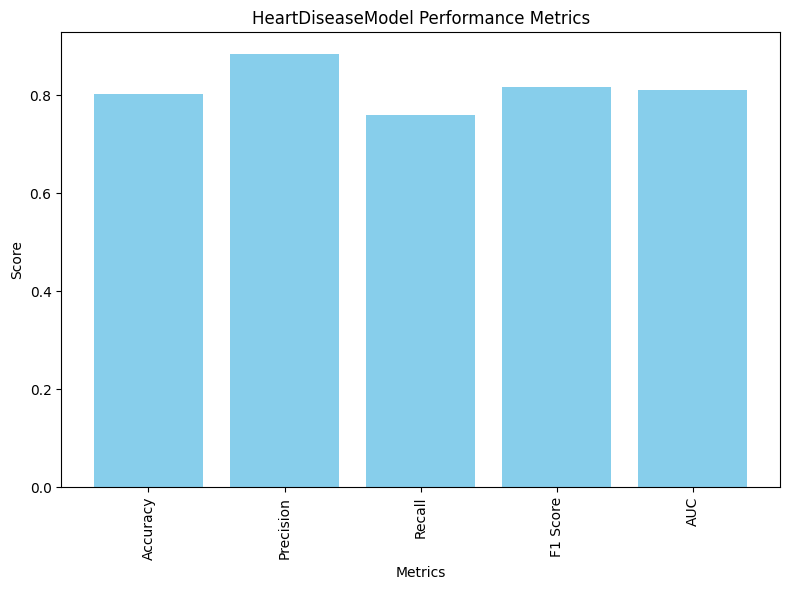

In [125]:
metrics = [accuracy, precision, recall, f1, auc]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
x = np.arange(len(metrics))

plt.figure(figsize=(8, 6))
plt.bar(x, metrics, color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('HeartDiseaseModel Performance Metrics')
plt.xticks(x, labels, rotation='vertical')
plt.tight_layout()
plt.show()


# Testing Different Epochs (100 - 5000)

In [126]:
def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_logits = model(x_test_tensor)
        y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

    y_true = y_test_tensor.numpy().reshape(-1)

    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return confusion, accuracy, precision, recall, f1, auc


# Define model, loss function, and optimizer
model = HeartDiseaseModel(input_size=x_train_tensor.shape[1], output_size=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert DataFrames directly to PyTorch tensors
x_train_tensor = torch.tensor(x_train.values.astype('float32'))
y_train_tensor = torch.tensor(y_train.values.astype('float32')).view(-1, 1)  # Ensure y_train is 2D
x_test_tensor = torch.tensor(x_test.values.astype('float32'))
y_test_tensor = torch.tensor(y_test.values.astype('float32')).view(-1, 1)


# List of epochs to test using range
epochs_to_test = list(range(100, 5000, 200))

# Results dictionary to store metrics for each epoch
results = {}

for epochs in epochs_to_test:
    confusion, accuracy, precision, recall, f1, auc = train_and_evaluate_model(
        model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs
    )

    results[epochs] = {
        "confusion": confusion,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }

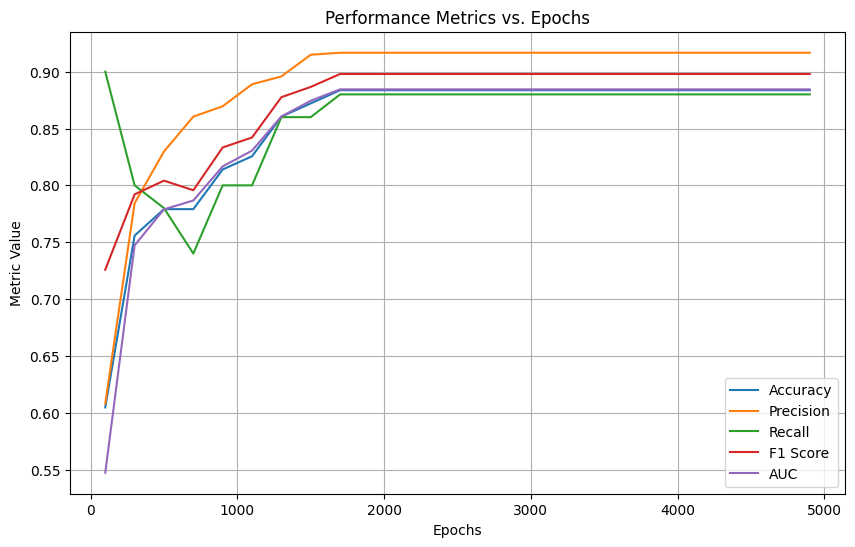

In [127]:
# Create lists to store metrics for plotting
accuracy_list = [metrics["accuracy"] for metrics in results.values()]
precision_list = [metrics["precision"] for metrics in results.values()]
recall_list = [metrics["recall"] for metrics in results.values()]
f1_list = [metrics["f1"] for metrics in results.values()]
auc_list = [metrics["auc"] for metrics in results.values()]

# Plotting the metrics
plt.figure(figsize=(10, 6))

plt.plot(epochs_to_test, accuracy_list, label='Accuracy')
plt.plot(epochs_to_test, precision_list, label='Precision')
plt.plot(epochs_to_test, recall_list, label='Recall')
plt.plot(epochs_to_test, f1_list, label='F1 Score')
plt.plot(epochs_to_test, auc_list, label='AUC')

plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


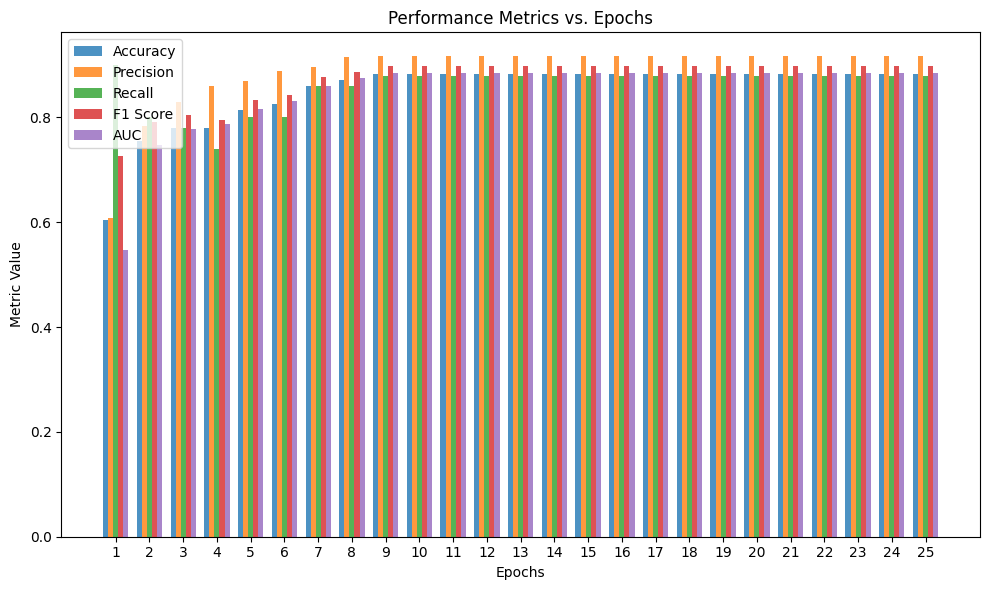

In [128]:
# Create lists to store metrics for plotting
accuracy_list = [metrics["accuracy"] for metrics in results.values()]
precision_list = [metrics["precision"] for metrics in results.values()]
recall_list = [metrics["recall"] for metrics in results.values()]
f1_list = [metrics["f1"] for metrics in results.values()]
auc_list = [metrics["auc"] for metrics in results.values()]
epochs_to_test = list(range(1, len(results) + 1))

# Plotting the metrics
plt.figure(figsize=(10, 6))

bar_width = 0.15
index = list(range(len(epochs_to_test)))

plt.bar(index, accuracy_list, bar_width, label='Accuracy', alpha=0.8)
plt.bar([i + bar_width for i in index], precision_list, bar_width, label='Precision', alpha=0.8)
plt.bar([i + 2 * bar_width for i in index], recall_list, bar_width, label='Recall', alpha=0.8)
plt.bar([i + 3 * bar_width for i in index], f1_list, bar_width, label='F1 Score', alpha=0.8)
plt.bar([i + 4 * bar_width for i in index], auc_list, bar_width, label='AUC', alpha=0.8)

plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Epochs')
plt.xticks([i + 2 * bar_width for i in index], epochs_to_test)
plt.legend()
plt.tight_layout()
plt.show()

In [129]:
def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    best_metrics = {
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1": 0,
        "auc": 0,
        "epoch": 0
    }

    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_logits = model(x_test_tensor)
            y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

        y_true = y_test_tensor.numpy().reshape(-1)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)

        # Check if this epoch has better metrics
        if accuracy > best_metrics["accuracy"]:
            best_metrics["accuracy"] = accuracy
            best_metrics["precision"] = precision
            best_metrics["recall"] = recall
            best_metrics["f1"] = f1
            best_metrics["auc"] = auc
            best_metrics["epoch"] = epoch

    return best_metrics


# Define model, loss function, and optimizer
model = HeartDiseaseModel(input_size=x_train_tensor.shape[1], output_size=1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert DataFrames directly to PyTorch tensors
x_train_tensor = torch.tensor(x_train.values.astype('float32'))
y_train_tensor = torch.tensor(y_train.values.astype('float32')).view(-1, 1)  # Ensure y_train is 2D
x_test_tensor = torch.tensor(x_test.values.astype('float32'))
y_test_tensor = torch.tensor(y_test.values.astype('float32')).view(-1, 1)

# List of epochs to test using range
epochs_to_test = list(range(100, 5000, 200))

# Results dictionary to store metrics for each epoch
results = {}

for epochs in epochs_to_test:
    best_metrics = train_and_evaluate_model(
        model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs
    )

    results[epochs] = best_metrics

# Print results for each epoch
for epochs, metrics in results.items():
    print(f"Results for {epochs} epochs:")
    print("Best Epoch:", metrics["epoch"])
    print("Accuracy:", metrics["accuracy"])
    print("Precision:", metrics["precision"])
    print("Recall:", metrics["recall"])
    print("F1 Score:", metrics["f1"])
    print("AUC:", metrics["auc"])
    print("="*40)

Results for 100 epochs:
Best Epoch: 99
Accuracy: 0.6395348837209303
Precision: 0.7714285714285715
Recall: 0.54
F1 Score: 0.6352941176470589
AUC: 0.6588888888888889
Results for 300 epochs:
Best Epoch: 237
Accuracy: 0.7674418604651163
Precision: 0.8125
Recall: 0.78
F1 Score: 0.7959183673469388
AUC: 0.765
Results for 500 epochs:
Best Epoch: 492
Accuracy: 0.8255813953488372
Precision: 0.8571428571428571
Recall: 0.84
F1 Score: 0.8484848484848485
AUC: 0.8227777777777777
Results for 700 epochs:
Best Epoch: 270
Accuracy: 0.8372093023255814
Precision: 0.86
Recall: 0.86
F1 Score: 0.8599999999999999
AUC: 0.8327777777777777
Results for 900 epochs:
Best Epoch: 675
Accuracy: 0.8604651162790697
Precision: 0.8958333333333334
Recall: 0.86
F1 Score: 0.8775510204081632
AUC: 0.8605555555555555
Results for 1100 epochs:
Best Epoch: 0
Accuracy: 0.8604651162790697
Precision: 0.8958333333333334
Recall: 0.86
F1 Score: 0.8775510204081632
AUC: 0.8605555555555555
Results for 1300 epochs:
Best Epoch: 694
Accuracy: 

# Expirementing with amount of layers

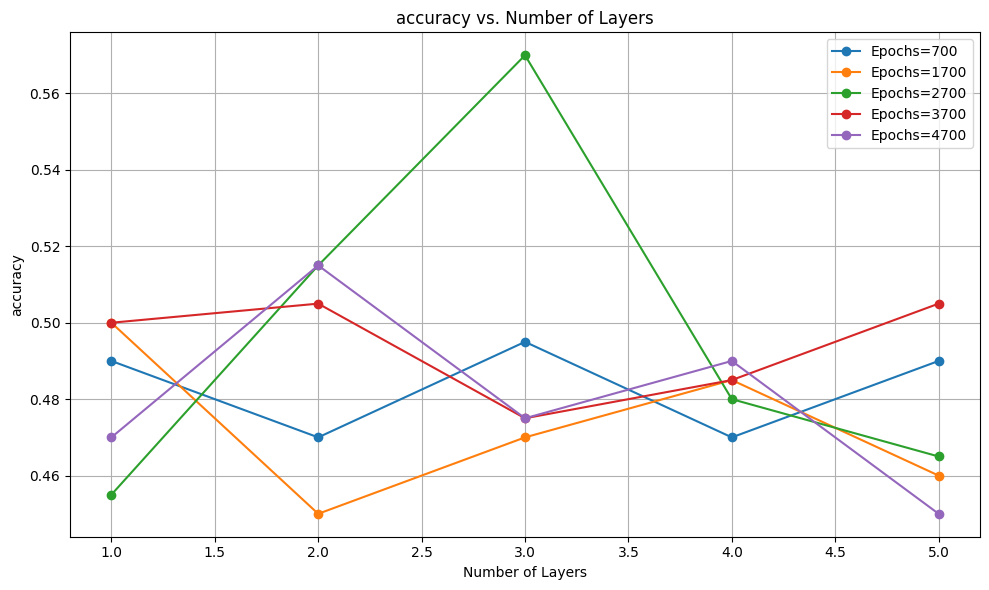

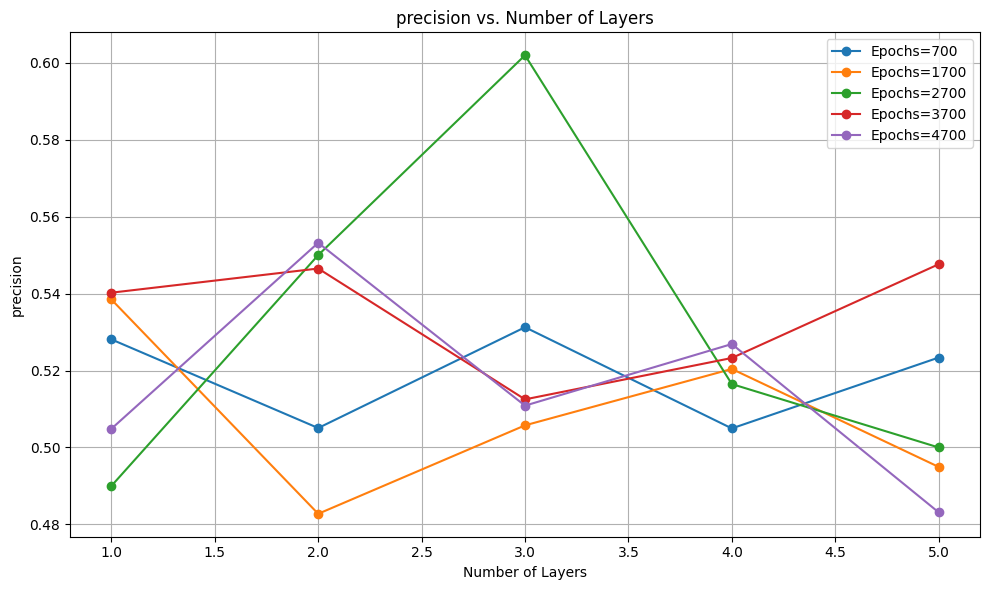

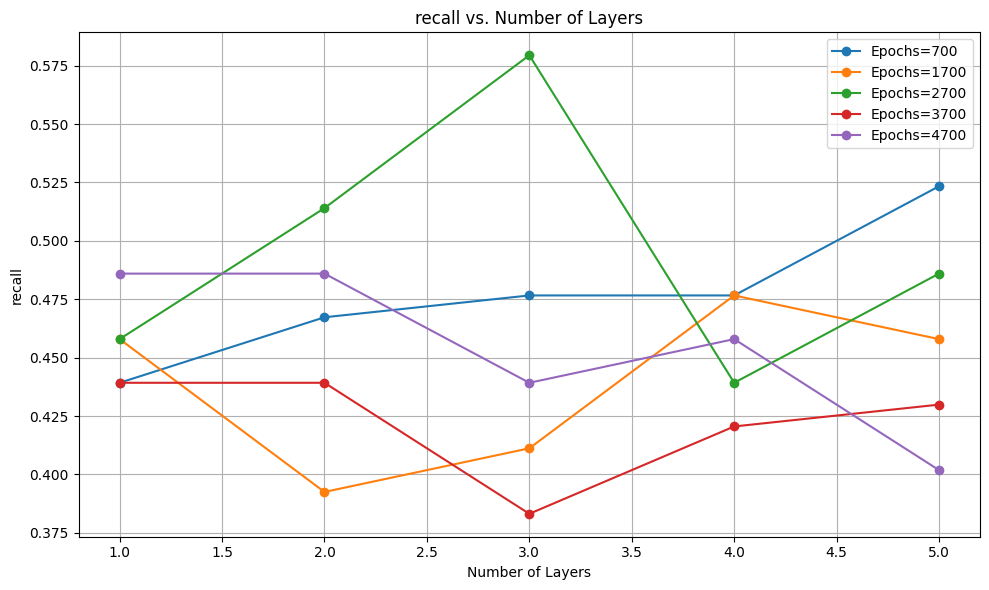

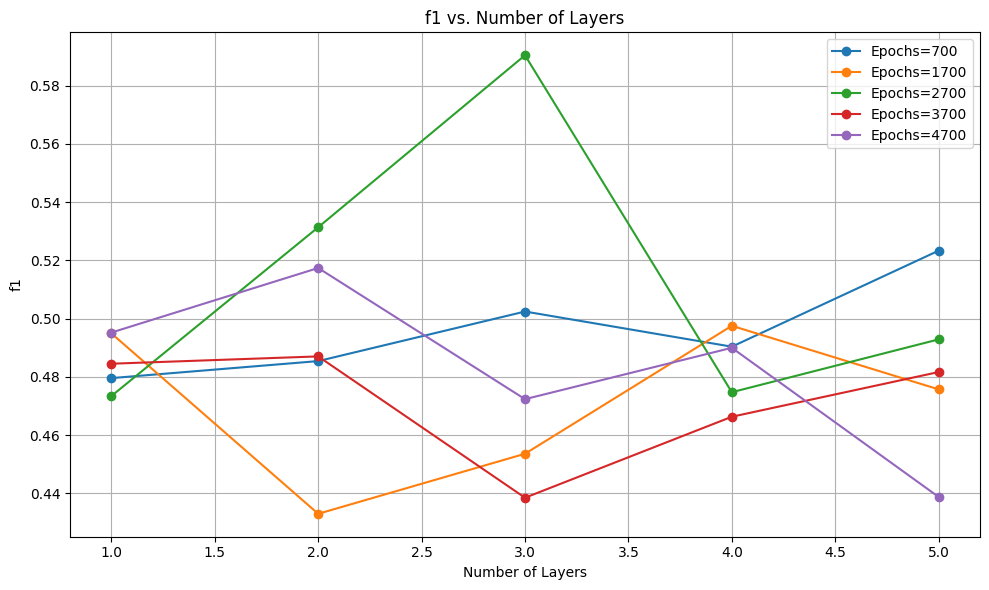

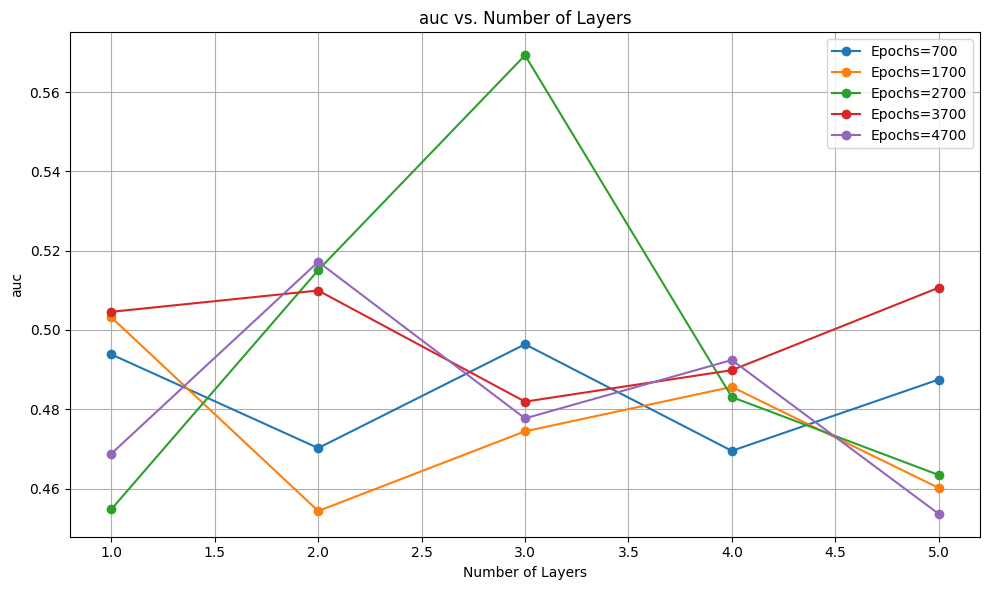

In [130]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, output_size, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(input_size, input_size) for _ in range(num_layers)])
        self.final_layer = nn.Linear(input_size, output_size)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = torch.relu(x)
        x = self.final_layer(x)
        return x

def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_logits = model(x_test_tensor)
        y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

    y_true = y_test_tensor.numpy().reshape(-1)

    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return confusion, accuracy, precision, recall, f1, auc

# Create sample data
np.random.seed(0)
x_train_selected = np.random.rand(1000, 10)
y_train = np.random.randint(0, 2, 1000)
x_test_selected = np.random.rand(200, 10)
y_test = np.random.randint(0, 2, 200)

# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensure y_train is 2D
x_test_tensor = torch.tensor(x_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)  # Ensure y_test is 2D

# List of number of layers and epochs to test
num_layers_list = [1, 2, 3, 4, 5]
epochs_list = [700, 1700, 2700, 3700, 4700]

# Results dictionaries to store metrics for each configuration
results_layers = {}
results_epochs = {}

# Evaluate with different numbers of layers at each specified epoch
for epoch in epochs_list:
    for num_layers in num_layers_list:
        model = HeartDiseaseModel(input_size=x_train_selected.shape[1], output_size=1, num_layers=num_layers)
        loss_fn = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        # Train and evaluate the model
        confusion, accuracy, precision, recall, f1, auc = train_and_evaluate_model(
            model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epoch
        )

        results_epochs.setdefault(epoch, {}).setdefault(num_layers, {
            "confusion": confusion,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc
        })

# Function to display results
def plot_results(results_dict, metric):
    plt.figure(figsize=(10, 6))
    for num_layers, metrics in results_dict.items():
        x = list(metrics.keys())
        y = [metric_result[metric] for metric_result in metrics.values()]
        plt.plot(x, y, marker='o', label=f'Epochs={num_layers}')

    plt.xlabel('Number of Layers')
    plt.ylabel(metric)
    plt.title(f'{metric} vs. Number of Layers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot results for different metrics
for metric in ["accuracy", "precision", "recall", "f1", "auc"]:
    plot_results(results_epochs, metric)



In [131]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x

def train_and_evaluate_model(model, loss_fn, optimizer, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epochs):
    model.train()
    for epoch in range(epochs):
        y_logits = model(x_train_tensor)
        loss = loss_fn(y_logits, y_train_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_logits = model(x_test_tensor)
        y_pred = torch.round(torch.sigmoid(test_logits)).detach().numpy().reshape(-1)

    y_true = y_test_tensor.numpy().reshape(-1)

    confusion = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    return confusion, accuracy, precision, recall, f1, auc

# Define your model, loss function, and optimizer
input_size = x_train_selected.shape[1]
output_size = 1
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam  # Corrected: Instantiate optimizer

# Convert numpy arrays directly to PyTorch tensors
x_train_tensor = torch.tensor(x_train_selected.astype('float32'))
y_train_tensor = torch.tensor(y_train.astype('float32')).view(-1, 1)  # Ensure y_train is 2D
x_test_tensor = torch.tensor(x_test_selected.astype('float32'))  # Corrected: Use x_test_selected
y_test_tensor = torch.tensor(y_test.astype('float32')).view(-1, 1)  # Ensure y_test is 2D

# List of number of layers and epochs to test
num_layers_list = [1, 2, 3, 4, 5]
epochs_list = [700, 1700, 2700, 3700, 4700]

# Results dictionaries to store metrics for each configuration
results_layers = {}
results_epochs = {}

# Evaluate with different numbers of layers at each specified epoch
for epoch in epochs_list:
    for num_layers in num_layers_list:
        model = HeartDiseaseModel(input_size, output_size)
        optimizer_instance = optimizer(model.parameters(), lr=0.001)  # Instantiate optimizer correctly

        # Train and evaluate the model
        confusion, accuracy, precision, recall, f1, auc = train_and_evaluate_model(
            model, loss_fn, optimizer_instance, x_train_tensor, y_train_tensor, x_test_tensor, y_test_tensor, epoch
        )

        results_epochs.setdefault(epoch, {}).setdefault(num_layers, {
            "confusion": confusion,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc
        })

# Function to display results
def display_results(results_dict, title):
    print(f"### {title}")
    print("Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC")
    print("---------------------------------------------------------------")
    for num_layers, metrics in results_dict.items():
        row = f"{num_layers:<16}"
        for metric, value in metrics.items():
            if isinstance(value, float):
                row += f"{value:.4f} | "
            else:
                row += f"{value} | "
        print(row[:-2])

# Display results for different numbers of layers
display_results(results_layers, "Model Performance with Varying Number of Layers")
print()

# Display results for different numbers of epochs
display_results(results_epochs, "Model Performance with Varying Number of Epochs")



### Model Performance with Varying Number of Layers
Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC
---------------------------------------------------------------

### Model Performance with Varying Number of Epochs
Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC
---------------------------------------------------------------
700             {'confusion': array([[74, 19],
       [83, 24]]), 'accuracy': 0.49, 'precision': 0.5581395348837209, 'recall': 0.22429906542056074, 'f1': 0.32, 'auc': 0.5099989950758718} | {'confusion': array([[70, 23],
       [80, 27]]), 'accuracy': 0.485, 'precision': 0.54, 'recall': 0.2523364485981308, 'f1': 0.3439490445859873, 'auc': 0.5025123103205708} | {'confusion': array([[73, 20],
       [85, 22]]), 'accuracy': 0.475, 'precision': 0.5238095238095238, 'recall': 0.205607476635514, 'f1': 0.29530201342281875, 'auc': 0.4952768565973269} | {'confusion': array([[68, 25],
       [80, 27]]), 'accuracy': 0.475, 'precision': 0.51

In [132]:
def display_results(results_dict, title):
    print(f"### {title}")
    print("Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC")
    print("---------------------------------------------------------------")
    for num_layers, metrics in results_dict.items():
        row = f"{num_layers:<16}"
        for metric, value in metrics.items():
            if isinstance(value, float):
                row += f"{value:.4f} | "
            else:
                row += f"{value} | "
        print(row[:-2])

# Display results for different numbers of layers
display_results(results_layers, "Model Performance with Varying Number of Layers")
print()

# Display results for different numbers of epochs
display_results(results_epochs, "Model Performance with Varying Number of Epochs")



### Model Performance with Varying Number of Layers
Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC
---------------------------------------------------------------

### Model Performance with Varying Number of Epochs
Number of Layers | Accuracy | Precision | Recall | F1 Score | AUC
---------------------------------------------------------------
700             {'confusion': array([[74, 19],
       [83, 24]]), 'accuracy': 0.49, 'precision': 0.5581395348837209, 'recall': 0.22429906542056074, 'f1': 0.32, 'auc': 0.5099989950758718} | {'confusion': array([[70, 23],
       [80, 27]]), 'accuracy': 0.485, 'precision': 0.54, 'recall': 0.2523364485981308, 'f1': 0.3439490445859873, 'auc': 0.5025123103205708} | {'confusion': array([[73, 20],
       [85, 22]]), 'accuracy': 0.475, 'precision': 0.5238095238095238, 'recall': 0.205607476635514, 'f1': 0.29530201342281875, 'auc': 0.4952768565973269} | {'confusion': array([[68, 25],
       [80, 27]]), 'accuracy': 0.475, 'precision': 0.51

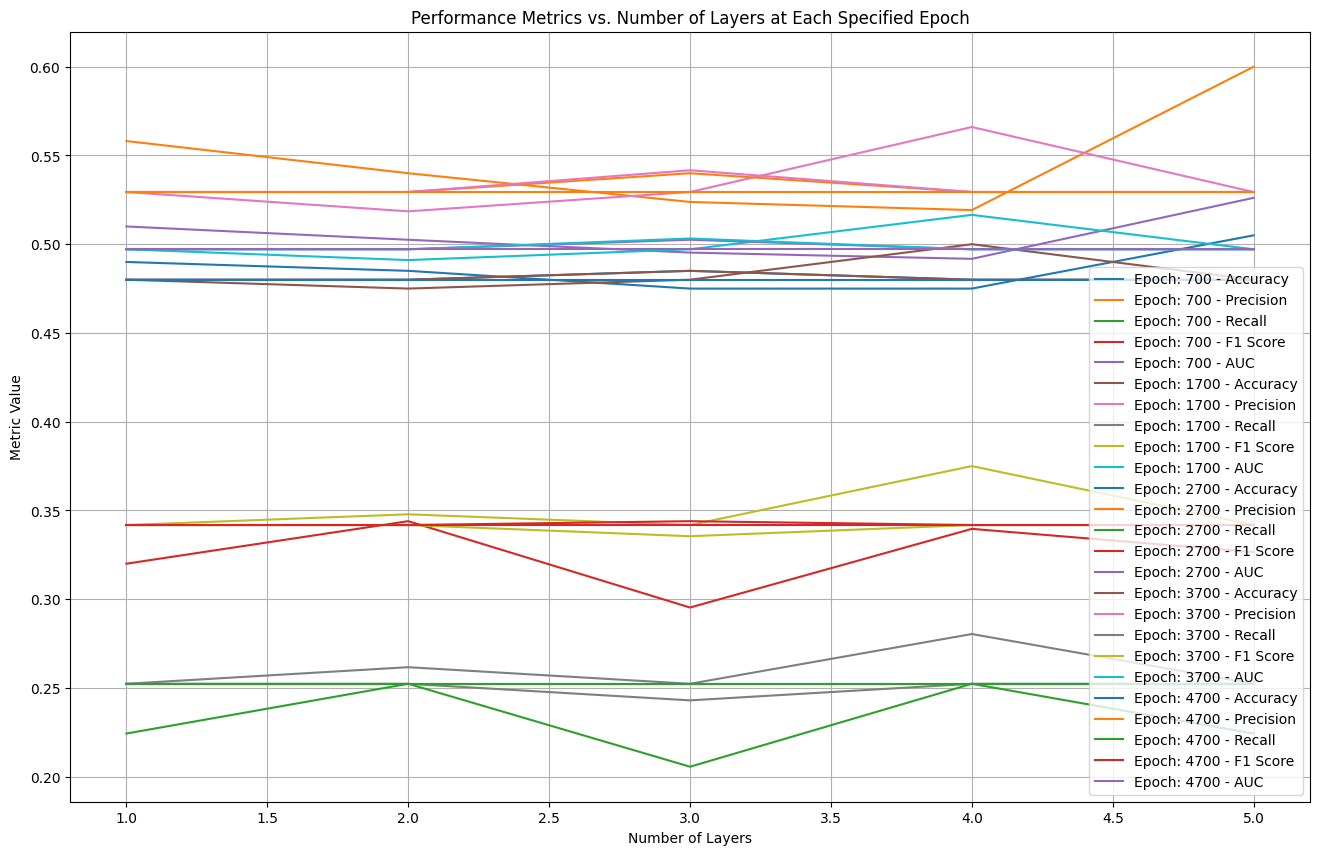

In [133]:
# Print and plot results for different numbers of layers at each specified epoch
plt.figure(figsize=(16, 10))

for epoch, layers_dict in results_epochs.items():
    accuracy_list = [metrics["accuracy"] for metrics in layers_dict.values()]
    precision_list = [metrics["precision"] for metrics in layers_dict.values()]
    recall_list = [metrics["recall"] for metrics in layers_dict.values()]
    f1_list = [metrics["f1"] for metrics in layers_dict.values()]
    auc_list = [metrics["auc"] for metrics in layers_dict.values()]

    plt.plot(num_layers_list, accuracy_list, label=f'Epoch: {epoch} - Accuracy')
    plt.plot(num_layers_list, precision_list, label=f'Epoch: {epoch} - Precision')
    plt.plot(num_layers_list, recall_list, label=f'Epoch: {epoch} - Recall')
    plt.plot(num_layers_list, f1_list, label=f'Epoch: {epoch} - F1 Score')
    plt.plot(num_layers_list, auc_list, label=f'Epoch: {epoch} - AUC')

plt.xlabel('Number of Layers')
plt.ylabel('Metric Value')
plt.title('Performance Metrics vs. Number of Layers at Each Specified Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
# Load the data
data = pd.read_csv("heart_data.csv")

# Check for missing values
missing_values = data.isnull().sum()
# Display the first few rows of the dataframe
print(data.head())

# Calculate quartiles and IQR for 'trestbps', 'chol', and 'oldpeak'
Q1 = data[['trestbps', 'chol', 'thalach', 'oldpeak']].quantile(0.25)
Q3 = data[['trestbps', 'chol', 'thalach', 'oldpeak']].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers using IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Clip outliers
data['trestbps'] = data['trestbps'].clip(lower=lower_bound['trestbps'], upper=upper_bound['trestbps'])
data['chol'] = data['chol'].clip(lower=lower_bound['chol'], upper=upper_bound['chol'])
data['thalach'] = data['thalach'].clip(lower=lower_bound['thalach'], upper=upper_bound['thalach'])
data['oldpeak'] = data['oldpeak'].clip(lower=lower_bound['oldpeak'], upper=upper_bound['oldpeak'])

# Split the data into features (X) and target (y)
x = data.drop('target', axis=1)
y = data['target']

# Convert to PyTorch tensors
x = torch.tensor(x.values).type(torch.float)
y = torch.tensor(y.values).type(torch.float)

# Split the data into 70% training and 30% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Print the shapes to verify the split
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
x_train shape: torch.Size([212, 13])
x_test shape: torch.Size([91, 13])
y_train shape: torch.Size([212])
y_test shape: torch.Size([91])


In [135]:
# Define boolean columns (assuming these might not exist)
bool_cols = ['thal_2', 'sex_1', 'exang_1', 'slope_2', 'slope_1', 'thal_1', 'ca_1', 'cp_1', 'cp_2']

# Split the data into features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target']

# Split the data into 70% training and 30% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Print column names of x_train DataFrame
print("Column names in x_train DataFrame:", x_train.columns)

# Try converting boolean columns, ignoring errors if they don't exist
try:
  x_train[bool_cols] = x_train[bool_cols].astype(int)
  x_test[bool_cols] = x_test[bool_cols].astype(int)
except KeyError:
  print("Some boolean columns might be missing. Ignoring conversion.")

# Define numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Apply MinMaxScaler to 'age' column
age_scaler = MinMaxScaler()
x_train['scaled_age'] = age_scaler.fit_transform(x_train[['age']])
x_test['scaled_age'] = age_scaler.transform(x_test[['age']])

# Apply StandardScaler to other numerical columns
z_score_scaler = StandardScaler()
x_train[numerical_cols] = z_score_scaler.fit_transform(x_train[numerical_cols])
x_test[numerical_cols] = z_score_scaler.transform(x_test[numerical_cols])

# Convert DataFrames directly to PyTorch tensors
x_train_tensor = torch.tensor(x_train.values.astype('float32'))
y_train_tensor = torch.tensor(y_train.values.astype('float32')).view(-1, 1)  # Ensure y_train is 2D
x_test_tensor = torch.tensor(x_test.values.astype('float32'))
y_test_tensor = torch.tensor(y_test.values.astype('float32')).view(-1, 1)  # Ensure y_test is 2D

# Print the shapes to verify the split
print("x_train shape:", x_train_tensor.shape)
print("y_train shape:", y_train_tensor.shape)
print("x_test shape:", x_test_tensor.shape)

Column names in x_train DataFrame: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')
Some boolean columns might be missing. Ignoring conversion.
x_train shape: torch.Size([212, 14])
y_train shape: torch.Size([212, 1])
x_test shape: torch.Size([91, 14])
